In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:33653' processes=0 threads=0, memory=0 B>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm
import xeofs as xe

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
cfg_var_MOC=CESM2_config()
cfg_var_MOC.year_s=1955
cfg_var_MOC.year_e=2020
cfg_var_MOC.setvar('MOC')

if cfg_var_MOC.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')

start_date = cftime.DatetimeNoLeap(cfg_var_MOC.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_MOC.year_e+1, 1, 1)

# Read files (functions)

In [5]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 
          'moc_components', 'transport_components', 
          'transport_regions', 'moc_z', 'lat_aux_grid', cfg_var_MOC.var]


def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds= ds.sel(time=slice(sd, ed)).isel(lev=slice(1, 11))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', 'dco2']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs_fgco2(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', 'fgco2_smoothed']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        # ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)



# Read files (Wind data assimilation)

In [6]:
#Read WDA dataset
start_time = time.time()

#MOC
cfg_var_MOC.WDA_path_load(cfg_var_MOC.var)
cfg_var_MOC.WDA_ds = xr.open_mfdataset(cfg_var_MOC.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_MOC.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_MOC.WDA_ds = cfg_var_MOC.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_MOC.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_MOC.WDA_ds.time))
cfg_var_MOC.WDA_ds = cfg_var_MOC.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))

elasped time for reading WDA: 5.7917304039001465


# Read files (All (OCN+wind) data assimilation)

In [7]:
#Read ADA dataset
start_time = time.time()

#MOC
cfg_var_MOC.ADA_path_load(cfg_var_MOC.var)
cfg_var_MOC.ADA_ds = xr.open_mfdataset(cfg_var_MOC.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_MOC.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_MOC.ADA_ds = cfg_var_MOC.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_MOC.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_MOC.ADA_ds.time))
cfg_var_MOC.ADA_ds = cfg_var_MOC.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 54.4129581451416


# Read files (Large Ensemble)

In [8]:
# Read LE dataset

start_time = time.time()

# MOC
cfg_var_MOC.LE_path_load(cfg_var_MOC.var)
cfg_var_MOC.LE_ds = xr.open_mfdataset(cfg_var_MOC.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_MOC.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_MOC.LE_ds = cfg_var_MOC.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_MOC.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_MOC.LE_ds.time))
cfg_var_MOC.LE_ds = cfg_var_MOC.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 170.70471501350403


# Read files (Ocean Data Assimilation)

In [9]:
# Read ODA dataset (projd only)

start_time = time.time()

#MOC
cfg_var_MOC.ODA_path_load(cfg_var_MOC.var)

cfg_var_MOC.ODA_ds = xr.open_mfdataset(cfg_var_MOC.ODA_file_list[0][10:20], 
                           chunks={'time': 2}, 
                           combine='nested', 
                           concat_dim=[[*cfg_var_MOC.ODA_ensembles[10:20]], 'time'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords(ds, start_date, end_date),
                           decode_cf=True, 
                           decode_times=True)

cfg_var_MOC.ODA_ds = cfg_var_MOC.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_MOC.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_MOC.ODA_ds.time))
cfg_var_MOC.ODA_ds = cfg_var_MOC.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))

elasped time for reading ODA: 58.23035192489624


# Read files (Observation)

In [10]:
# # Read Observation dataset
# start_time = time.time()

# # FG_CO2
# cfg_var_FG_CO2.OBS_path_load(cfg_var_FG_CO2.var)
# cfg_var_FG_CO2.OBS_ds = xr.open_mfdataset(cfg_var_FG_CO2.OBS_file_list[0][0], 
#                        chunks={'time': 12}, 
#                        parallel=True,
#                        preprocess=lambda ds: process_coords_obs_fgco2(ds),
#                        decode_cf=True,)

# cfg_var_FG_CO2.OBS_ds = cfg_var_FG_CO2.OBS_ds.rename({cfg_var_FG_CO2.OBS_var: cfg_var_FG_CO2.var})

# # new_time = cfg_var_FG_CO2.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_FG_CO2.OBS_ds.time))
# # cfg_var_FG_CO2.OBS_ds = cfg_var_FG_CO2.OBS_ds.assign_coords(time=new_time)

# if cfg_var_FG_CO2.var=='SSH':
#     cfg_var_FG_CO2.OBS_ds=cfg_var_FG_CO2.OBS_ds.assign_coords(time=cfg_var_FG_CO2.ODA_ds.sel(time=slice("1993-01-01", "2020-12-31")).time) #1993~2020
# elif cfg_var_FG_CO2.var=='photoC_TOT_zint_100m':
#     cfg_var_FG_CO2.OBS_ds=cfg_var_FG_CO2.OBS_ds.assign_coords(time=cfg_var_FG_CO2.ODA_ds.sel(time=slice("1999-01-01", "2020-12-31")).time) #1999~2020
# elif cfg_var_FG_CO2.var=='FG_CO2':
#     cfg_var_FG_CO2.OBS_ds=cfg_var_FG_CO2.OBS_ds.assign_coords(time=cfg_var_FG_CO2.ODA_ds.sel(time=slice("1982-01-01", "2020-12-31")).time)
# elif cfg_var_FG_CO2.var=='DpCO2_ALT_CO2':
#     cfg_var_FG_CO2.OBS_ds=cfg_var_FG_CO2.OBS_ds.assign_coords(time=cfg_var_FG_CO2.ODA_ds.sel(time=slice("1982-01-01", "2020-12-31")).time)
# elif cfg_var_FG_CO2.var=='DpCO2':
#     cfg_var_FG_CO2.OBS_ds=cfg_var_FG_CO2.OBS_ds.assign_coords(time=cfg_var_FG_CO2.ODA_ds.sel(time=slice("1982-01-01", "2020-12-31")).time) #1982~2020
# cfg_var_FG_CO2.OBS_ds.time

# # global mean removal for SSH
# if cfg_var_FG_CO2.var=='SSH':
#     lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

#     area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
#     ssh_selected = cfg_var_FG_CO2.OBS_ds[cfg_var_FG_CO2.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

#     # 필터링된 지역에 대해 global mean 계산
#     cfg_var_FG_CO2.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
#     # 원 데이터에서 global mean을 제거한 값
#     cfg_var_FG_CO2.OBS_ds['SSH'] = cfg_var_FG_CO2.OBS_ds[cfg_var_FG_CO2.var] - cfg_var_FG_CO2.OBS_ds['gm']


# # Step 1: 결측값이 아닌 값의 비율 계산
# # 결측값이 아닌 값들에 대해 True, 결측값에 대해 False로 표시
# valid_data_count = (~cfg_var_FG_CO2.OBS_ds[cfg_var_FG_CO2.var].isnull()).sum(dim='time')
# # Step 2: 전체 시간 축의 길이 (즉, 데이터가 있어야 할 총 시간 개수)
# total_time_steps = cfg_var_FG_CO2.OBS_ds['time'].size
# # Step 3: 80% 이상의 값이 있는지 계산
# # 비율 계산 후, 80% 이상이면 True, 그렇지 않으면 False로 표시
# threshold = 0.8
# mask = (valid_data_count / total_time_steps) >= threshold
# # Step 4: 마스크 변수를 데이터셋에 추가
# cfg_var_FG_CO2.OBS_ds['mask_80_percent'] = mask
# cfg_var_FG_CO2.OBS_ds['mask_80_percent'].compute()

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading OBS: ' + str(elapsed_time))

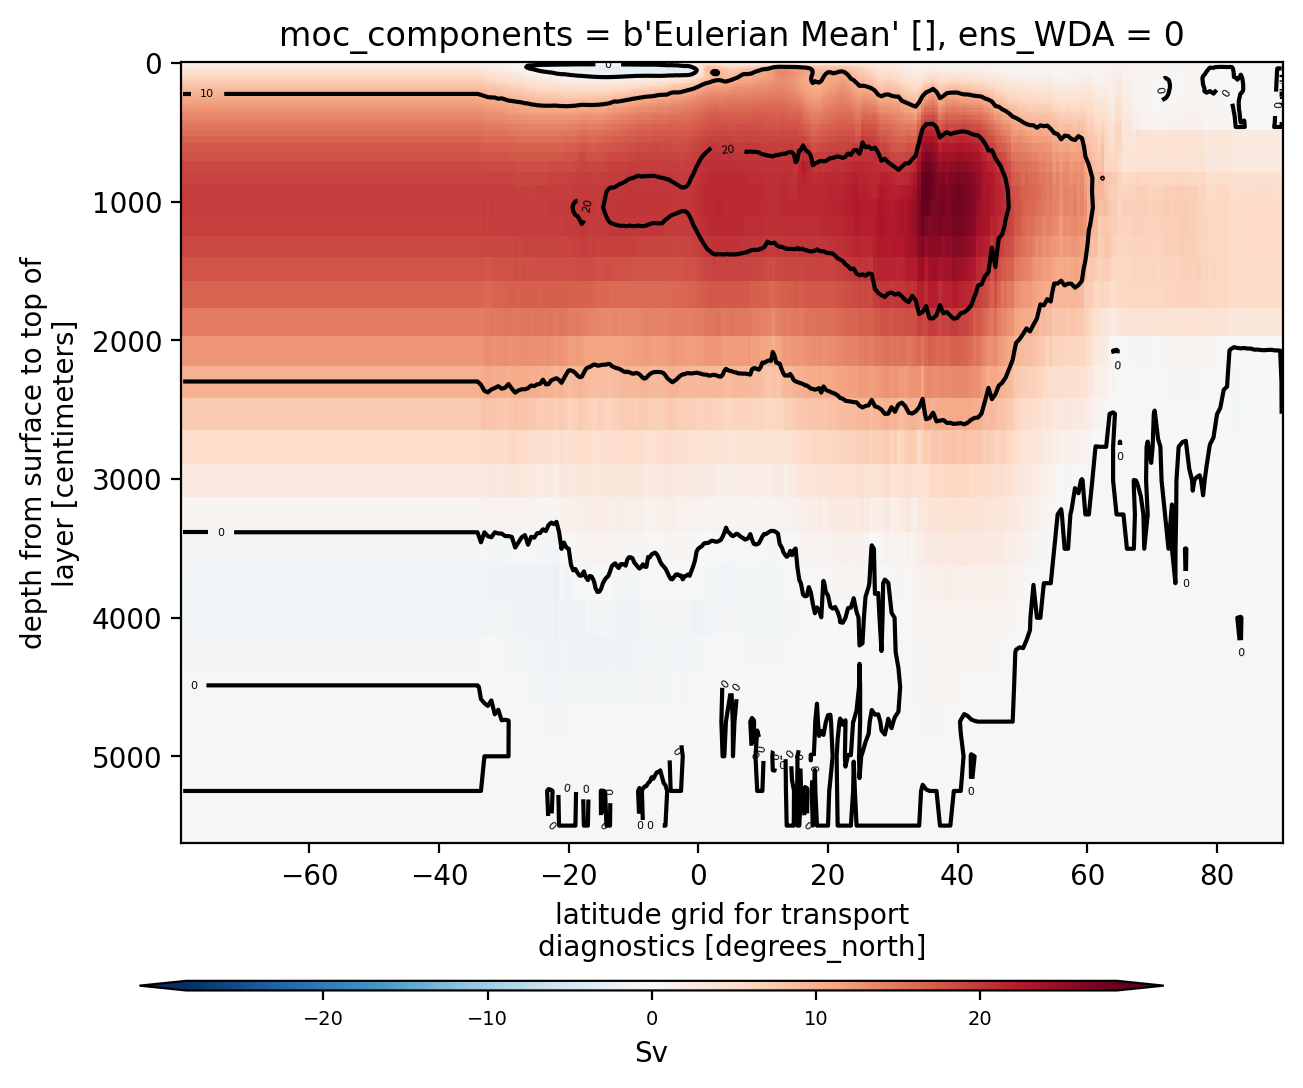

In [11]:

cmap2 = plt.get_cmap('RdBu_r')
data_array=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).mean(dim='time')
data_array['lat_aux_grid']=cfg_var_MOC.WDA_ds['lat_aux_grid']
data_array['moc_z']=cfg_var_MOC.WDA_ds['moc_z']/100 #cm -> m

fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

plt2=data_array.plot.pcolormesh(x='lat_aux_grid', y='moc_z', ax=axes, cmap= cmap2, add_colorbar=False, extend='both')

cs = data_array.plot.contour(
    x='lat_aux_grid', y='moc_z', ax=axes, colors='black', linewidths=1.5,
    add_colorbar=False
)
axes.clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes.invert_yaxis()

cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt2, cax=cbar_a_c, orientation='horizontal', extend='both')
cbar1.set_label('Sv')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격


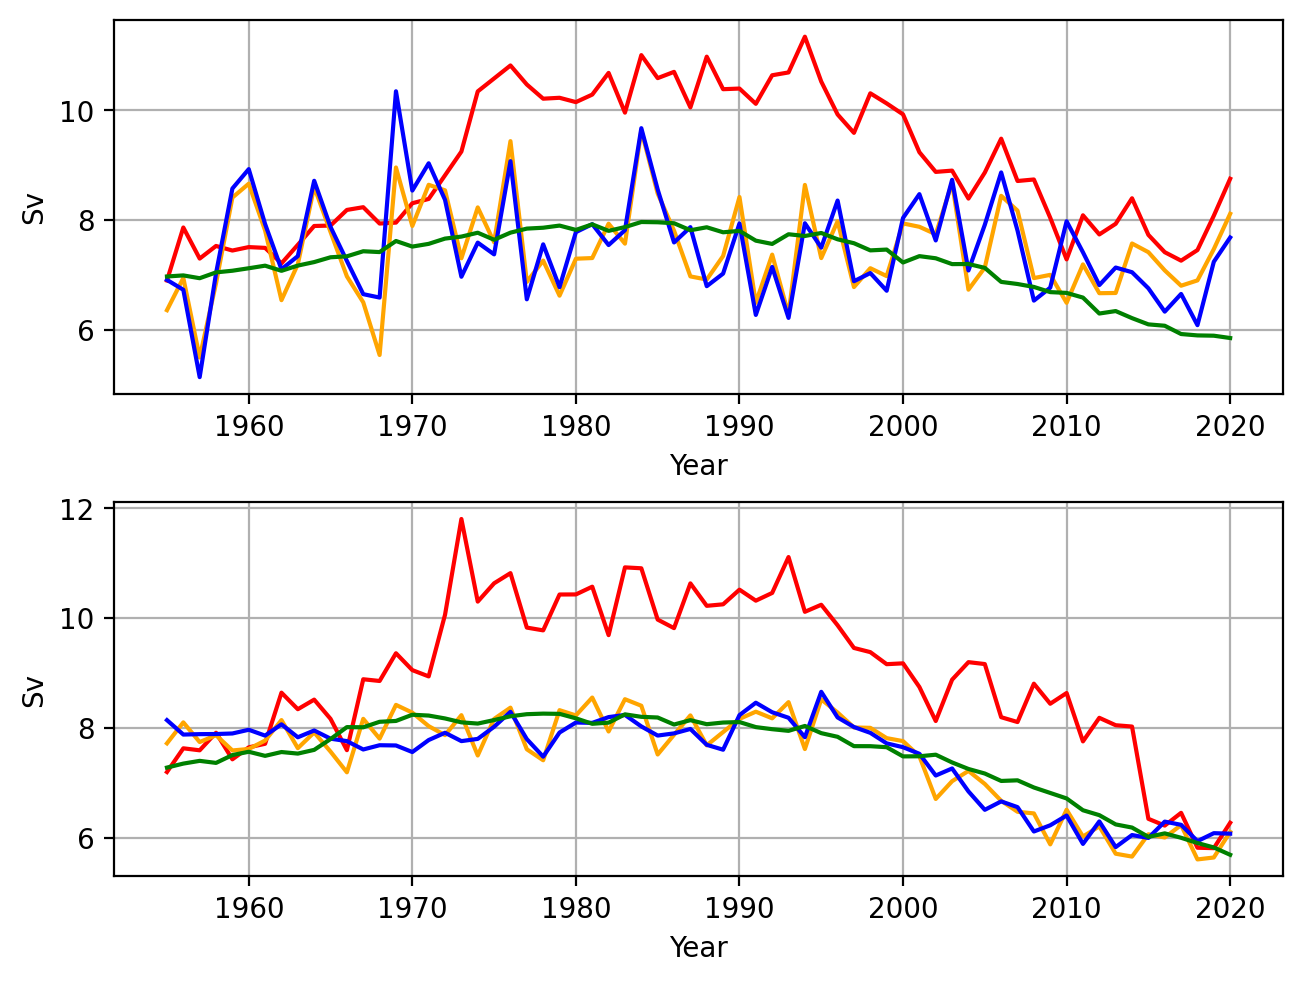

In [12]:
# AMOC at 26,45N weighted vertical mean

fig, axes = plt.subplots(nrows=2, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

data_array1_wda=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).sel(lat_aux_grid=26, method='nearest')

dz = np.diff(data_array1_wda.moc_z.values)  # length N-1
dz_with_zero = np.append(dz, 0.0)       # length N
moc_dz_da = xr.DataArray(
    dz_with_zero,
    coords={'moc_z': data_array1_wda.moc_z}, 
    dims=['moc_z']
)
data_array1_wda['moc_dz'] = moc_dz_da
data_array1_wda=data_array1_wda.groupby('time.year').mean(dim='time', skipna=True)*data_array1_wda['moc_dz']
data_array1_wda=data_array1_wda.sum(dim='moc_z') / data_array1_wda['moc_dz'].sum(dim='moc_z')

data_array1_oda=cfg_var_MOC.ODA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ODA').sel(lat_aux_grid=26, method='nearest')
data_array1_oda['moc_dz'] = moc_dz_da
data_array1_oda=data_array1_oda.groupby('time.year').mean(dim='time', skipna=True)*data_array1_oda['moc_dz']
data_array1_oda=data_array1_oda.sum(dim='moc_z') / data_array1_oda['moc_dz'].sum(dim='moc_z')

data_array1_ada=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ADA').sel(lat_aux_grid=26, method='nearest')
data_array1_ada['moc_dz'] = moc_dz_da
data_array1_ada=data_array1_ada.groupby('time.year').mean(dim='time', skipna=True)*data_array1_ada['moc_dz']
data_array1_ada=data_array1_ada.sum(dim='moc_z') / data_array1_ada['moc_dz'].sum(dim='moc_z')

data_array1_le=cfg_var_MOC.LE_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_LE').sel(lat_aux_grid=26, method='nearest')
data_array1_le['moc_dz'] = moc_dz_da
data_array1_le=data_array1_le.groupby('time.year').mean(dim='time', skipna=True)*data_array1_le['moc_dz']
data_array1_le=data_array1_le.sum(dim='moc_z') / data_array1_le['moc_dz'].sum(dim='moc_z')

# data_array2=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).sel(lat_aux_grid=45, method='nearest').groupby('time.year').mean(dim='time', skipna=True)
data_array2_wda=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).sel(lat_aux_grid=45, method='nearest')
data_array2_wda['moc_dz'] = moc_dz_da
data_array2_wda=data_array2_wda.groupby('time.year').mean(dim='time', skipna=True)*data_array2_wda['moc_dz']
data_array2_wda=data_array2_wda.sum(dim='moc_z') / data_array2_wda['moc_dz'].sum(dim='moc_z')

data_array2_oda=cfg_var_MOC.ODA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ODA').sel(lat_aux_grid=45, method='nearest')
data_array2_oda['moc_dz'] = moc_dz_da
data_array2_oda=data_array2_oda.groupby('time.year').mean(dim='time', skipna=True)*data_array2_oda['moc_dz']
data_array2_oda=data_array2_oda.sum(dim='moc_z') / data_array2_oda['moc_dz'].sum(dim='moc_z')

data_array2_ada=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ADA').sel(lat_aux_grid=45, method='nearest')
data_array2_ada['moc_dz'] = moc_dz_da
data_array2_ada=data_array2_ada.groupby('time.year').mean(dim='time', skipna=True)*data_array2_ada['moc_dz']
data_array2_ada=data_array2_ada.sum(dim='moc_z') / data_array2_ada['moc_dz'].sum(dim='moc_z')

data_array2_le=cfg_var_MOC.LE_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_LE').sel(lat_aux_grid=45, method='nearest')
data_array2_le['moc_dz'] = moc_dz_da
data_array2_le=data_array2_le.groupby('time.year').mean(dim='time', skipna=True)*data_array2_le['moc_dz']
data_array2_le=data_array2_le.sum(dim='moc_z') / data_array2_le['moc_dz'].sum(dim='moc_z')

axes[0].plot(data_array1_wda["year"], data_array1_wda, color="red", label="wda")
axes[0].plot(data_array1_ada["year"], data_array1_ada, color="orange", label="ada")
axes[0].plot(data_array1_oda["year"], data_array1_oda, color="blue", label="oda")
axes[0].plot(data_array1_le["year"], data_array1_le, color="green", label="le")

axes[0].set_xlabel("Year")
axes[0].set_ylabel("Sv")
axes[0].grid(True)

axes[1].plot(data_array1_wda["year"], data_array2_wda, color="red", label="wda")
axes[1].plot(data_array1_ada["year"], data_array2_ada, color="orange", label="ada")
axes[1].plot(data_array1_oda["year"], data_array2_oda, color="blue", label="oda")
axes[1].plot(data_array1_le["year"], data_array2_le, color="green", label="le")

axes[1].set_xlabel("Year")
axes[1].set_ylabel("Sv")
axes[1].grid(True)
plt.show()

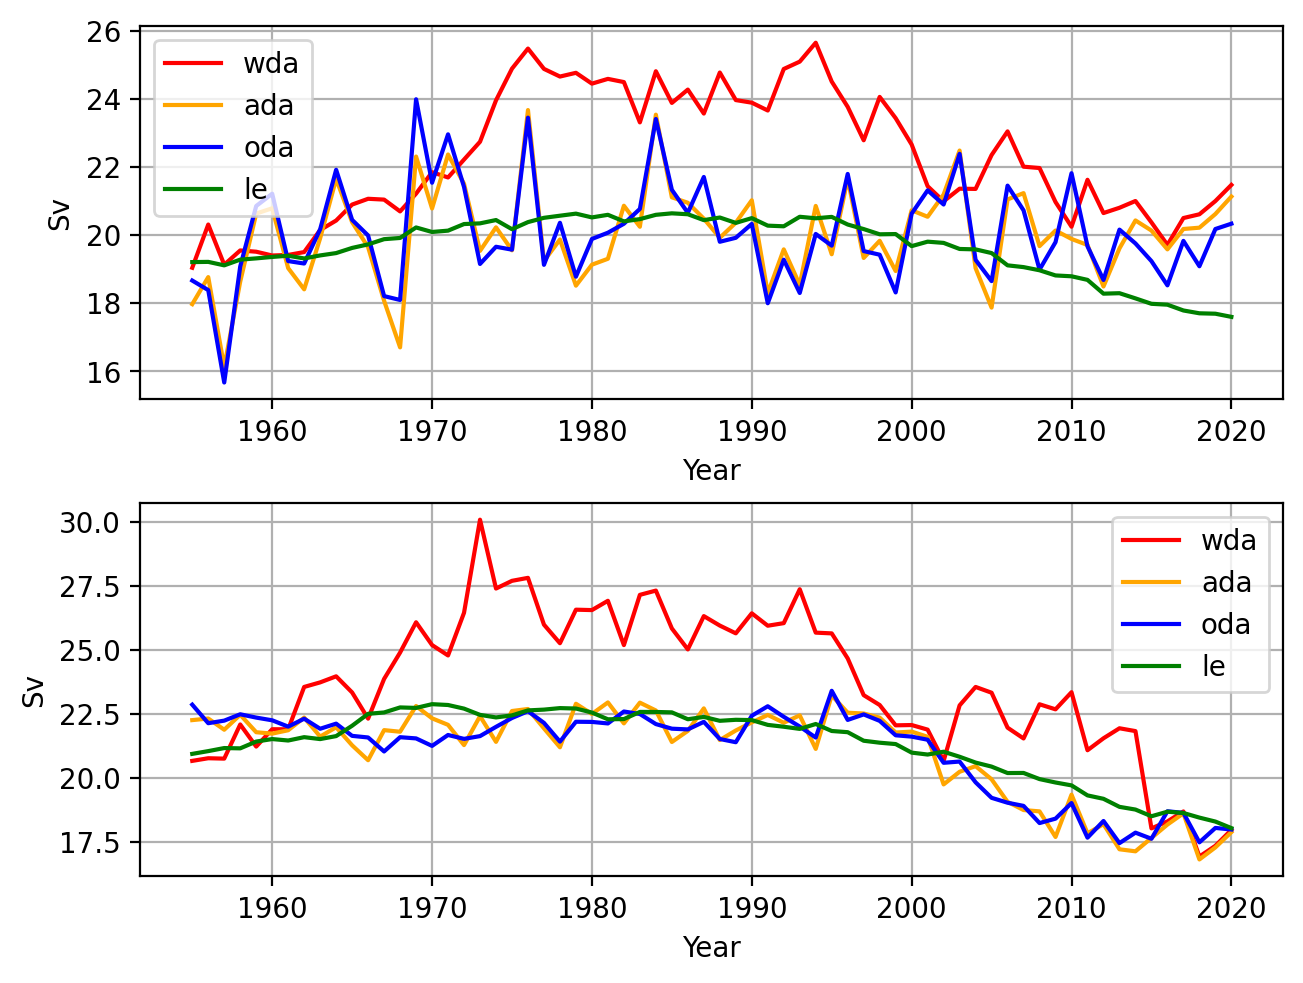

In [13]:
# AMOC at 26,45N strongest response

fig, axes = plt.subplots(nrows=2, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

data_array1_wda=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=26, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array1_oda=cfg_var_MOC.ODA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ODA').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=26, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array1_ada=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ADA').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=26, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array1_le=cfg_var_MOC.LE_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_LE').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=26, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')

data_array2_wda=cfg_var_MOC.WDA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_WDA=0).where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=45, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array2_oda=cfg_var_MOC.ODA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ODA').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=45, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array2_ada=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_ADA').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=45, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')
data_array2_le=cfg_var_MOC.LE_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).mean(dim='ens_LE').where(cfg_var_MOC.WDA_ds.moc_z > 50000, drop=True).sel(lat_aux_grid=45, method='nearest').groupby('time.year').mean(dim='time', skipna=True).max(dim='moc_z')


axes[0].plot(data_array1_wda["year"], data_array1_wda, color="red", label="wda")
axes[0].plot(data_array1_ada["year"], data_array1_ada, color="orange", label="ada")
axes[0].plot(data_array1_oda["year"], data_array1_oda, color="blue", label="oda")
axes[0].plot(data_array1_le["year"], data_array1_le, color="green", label="le")

axes[0].set_xlabel("Year")
axes[0].set_ylabel("Sv")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(data_array1_wda["year"], data_array2_wda, color="red", label="wda")
axes[1].plot(data_array1_ada["year"], data_array2_ada, color="orange", label="ada")
axes[1].plot(data_array1_oda["year"], data_array2_oda, color="blue", label="oda")
axes[1].plot(data_array1_le["year"], data_array2_le, color="green", label="le")

axes[1].set_xlabel("Year")
axes[1].set_ylabel("Sv")
axes[1].grid(True)
axes[1].legend()
plt.show()

In [16]:
data_array

<xarray.DataArray 'MOC' (year: 66, moc_z: 61, lat_aux_grid: 395)> Size: 6MB
dask.array<stack, shape=(66, 61, 395), dtype=float32, chunksize=(1, 61, 395), chunktype=numpy.ndarray>
Coordinates:
    moc_components  |S384 384B dask.array<chunksize=(), meta=np.ndarray>
  * lat_aux_grid    (lat_aux_grid) float32 2kB -79.49 -78.95 ... 89.47 90.0
  * moc_z           (moc_z) float32 244B 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ens_ADA         int64 8B 0
  * year            (year) int64 528B 1955 1956 1957 1958 ... 2018 2019 2020
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    cell_methods:  time: mean

In [23]:
# AMOC EOF

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_ADA=0).groupby('time.year').mean(dim='time', skipna=True)
data_array = data_array.rename({'lat_aux_grid': 'LAT'})

eofmodel = xe.single.EOF(n_modes=3, use_coslat=True)
eofmodel.fit(data_array, dim="year")
eofmodel.explained_variance_ratio()

eof_lv = eofmodel.components()
eof_pct=eofmodel.scores()
# components.sel(mode=1).plot()
# pct.plot()

In [25]:
eofmodel.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 3)> Size: 24B
array([0.27636892, 0.25144828, 0.11694024])
Coordinates:
    ens_ADA         int64 8B 0
    moc_components  |S13 13B b'Eulerian Mean'
  * mode            (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-03-03 16:06:42
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

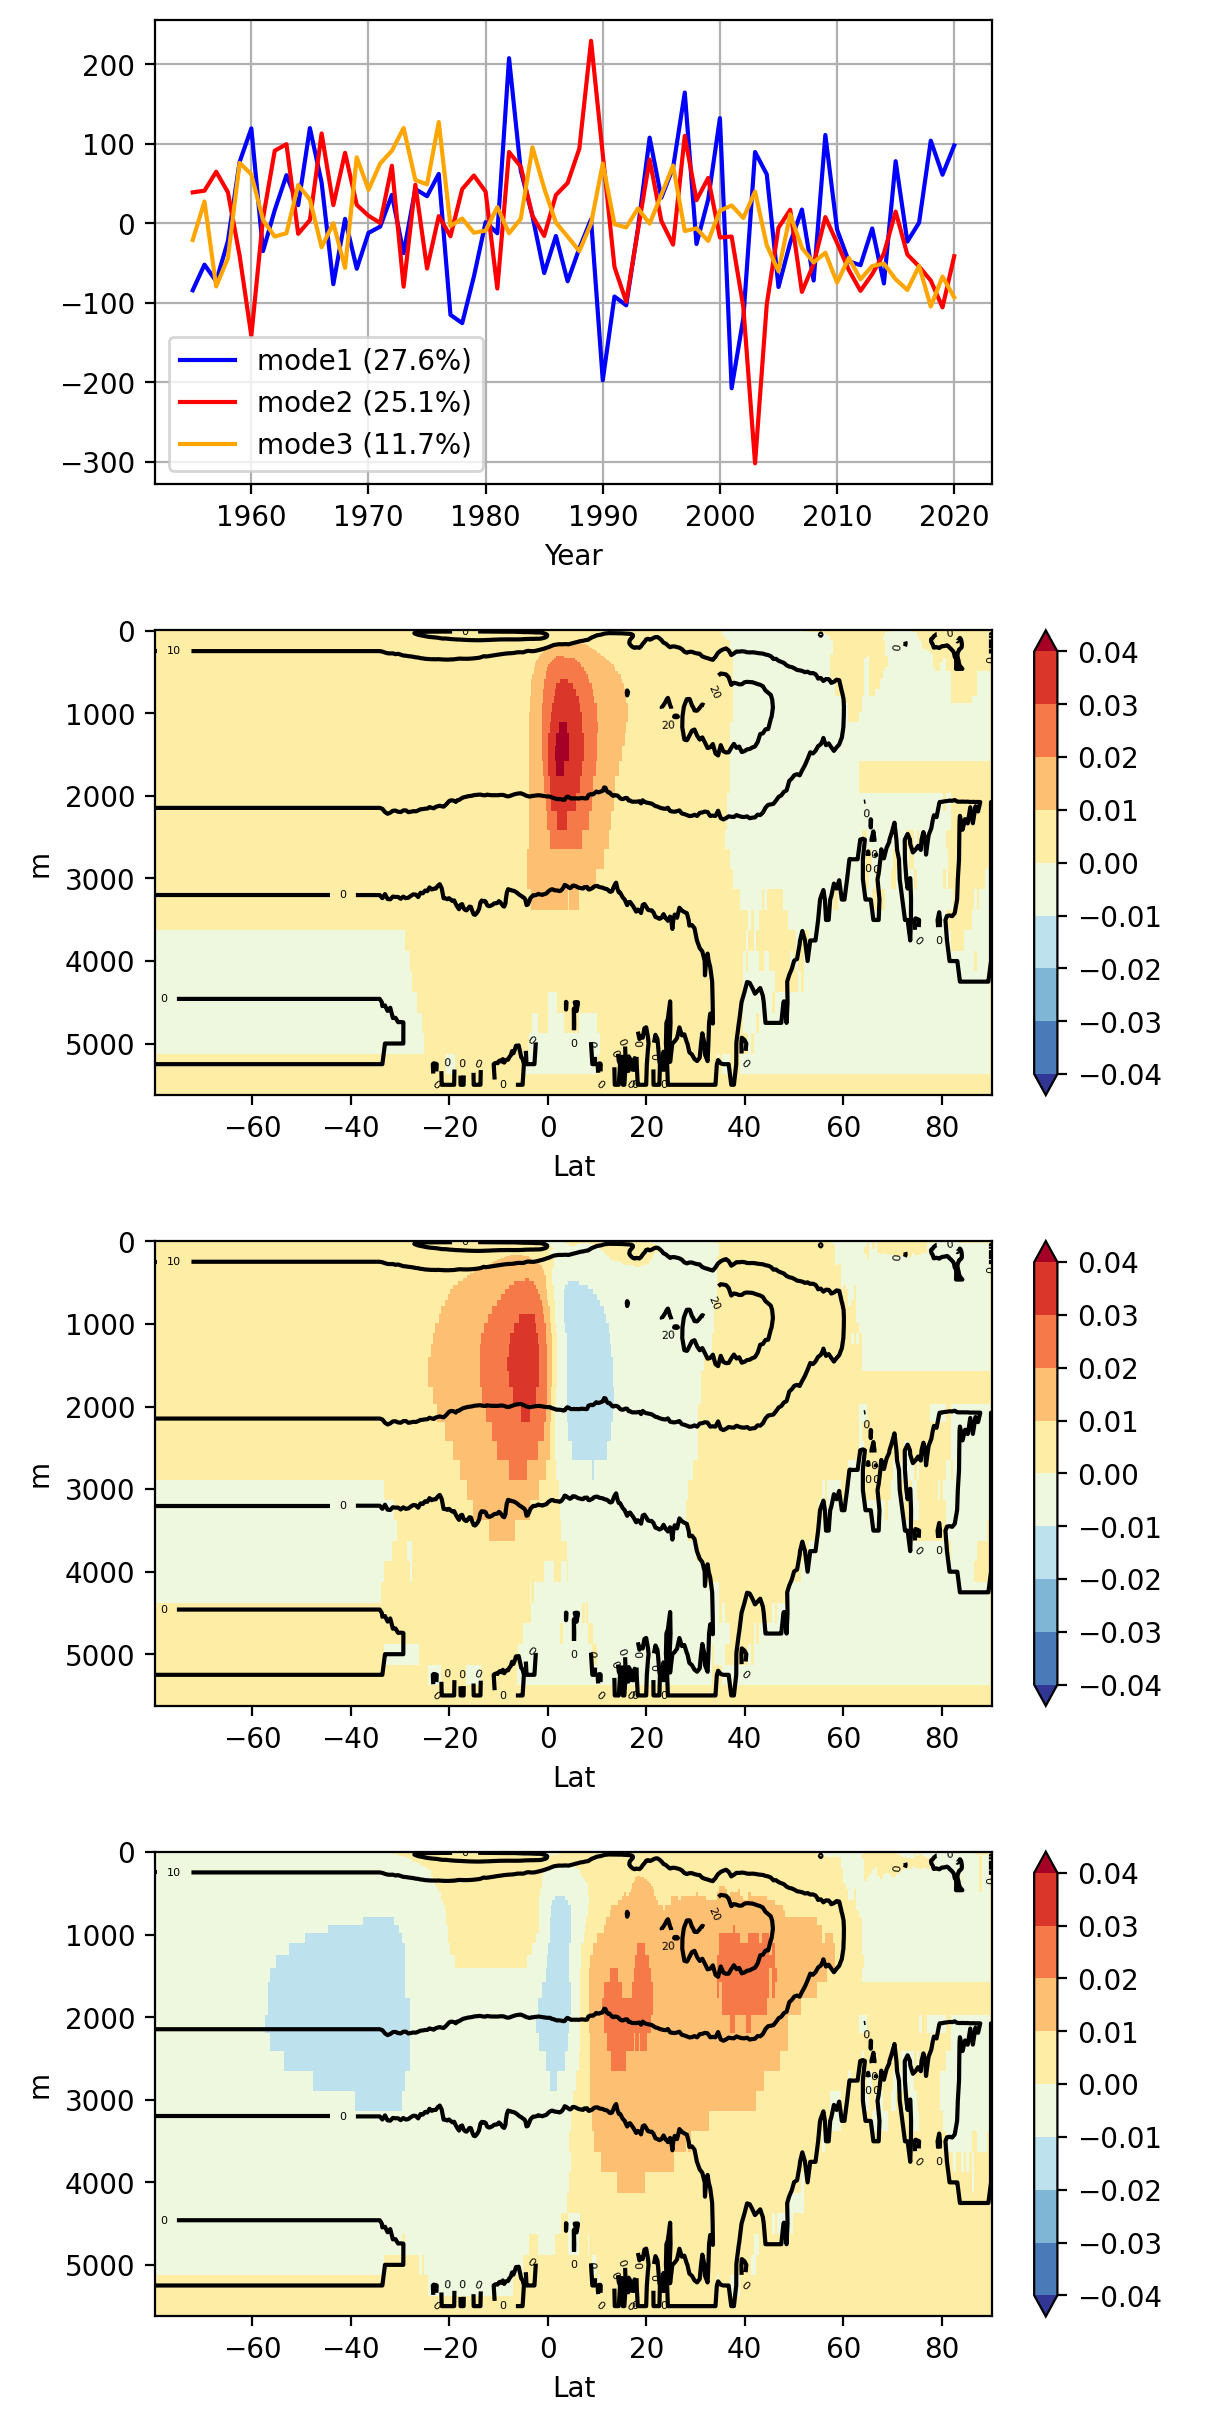

In [73]:
# AMOC EOF plots

levels = np.linspace(-0.04,0.04,9)
ticklevels = np.linspace(-0.04,0.04,9)
contour_levels = [-20, -10, 0, 10, 20]

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_ADA=0)
data_array=data_array.mean(dim='time')
data_array = data_array.rename({'lat_aux_grid': 'LAT'})
data_array['moc_z']=data_array['moc_z']/100 #cm -> m

eof_lv['moc_z']=data_array['moc_z'] #cm -> m

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 12),
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

axes[0].plot(eof_pct["year"], eof_pct.sel(mode=1), color="blue", label="mode1 (27.6%)")
axes[0].plot(eof_pct["year"], eof_pct.sel(mode=2), color="red", label="mode2 (25.1%)")
axes[0].plot(eof_pct["year"], eof_pct.sel(mode=3), color="orange", label="mode3 (11.7%)")

axes[0].set_xlabel("Year")
axes[0].set_ylabel(" ")
axes[0].grid(True)
axes[0].legend()

# cmap2 = plt.get_cmap('RdBu_r')
cmap2 = plt.get_cmap('RdYlBu_r')

# mode 1 lv
plt1=eof_lv.sel(mode=1).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[1], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[1], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1].invert_yaxis()
axes[1].set_xlabel("Lat")
axes[1].set_ylabel("m")
axes[1].set_title(" ")

# mode 2 lv
plt1=eof_lv.sel(mode=2).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[2], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[2], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[2].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2].invert_yaxis()
axes[2].set_xlabel("Lat")
axes[2].set_ylabel("m")
axes[2].set_title(" ")

# mode 3 lv
plt1=eof_lv.sel(mode=3).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[3], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[3], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[3].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3].invert_yaxis()
axes[3].set_xlabel("Lat")
axes[3].set_ylabel("m")
axes[3].set_title(" ")



# cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
# cbar1 = fig.colorbar(plt2, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('Sv')
# cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격



plt.show()

In [54]:
# global MOC EOF

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=0).isel(moc_comp=0).isel(ens_ADA=0).groupby('time.year').mean(dim='time', skipna=True)
data_array = data_array.rename({'lat_aux_grid': 'LAT'})

glo_eofmodel = xe.single.EOF(n_modes=3, use_coslat=True)
glo_eofmodel.fit(data_array, dim="year")
glo_eofmodel.explained_variance_ratio()

glo_eof_lv = glo_eofmodel.components()
glo_eof_pct = glo_eofmodel.scores()
# components.sel(mode=1).plot()
# pct.plot()
glo_eofmodel.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 3)> Size: 24B
array([0.28885462, 0.27343679, 0.08512693])
Coordinates:
    ens_ADA         int64 8B 0
    moc_components  |S13 13B b'Eulerian Mean'
  * mode            (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-03-03 17:39:21
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [63]:
# find max3, min1

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=0).isel(moc_comp=0).isel(ens_ADA=0).mean(dim='time')

# Suppose your DataArray is "data_array" with dims (moc_z, lat_aux_grid)
# shape = (61, 395)
vals = data_array.values  # shape (61, 395), a NumPy array

# 1) Flatten and sort indices
#    argsort gives ascending order. We'll get min -> max
flat = vals.ravel()  # shape (61*395,) = (24095,)
idx_sorted = np.argsort(flat)  # array of indices from smallest value to largest

# 2) Retrieve indices for min, second min, max, second max
idx_min = idx_sorted[0]       # index of absolute min
idx_max = idx_sorted[-1]      # index of absolute max
# idx_max2 = idx_sorted[-2]     # index of second max
# idx_max3 = idx_sorted[-3]     # index of third max

# 3) Convert these flat indices back to (moc_z_idx, lat_idx)
moc_z_idx_min, lat_idx_min = np.unravel_index(idx_min, vals.shape)
moc_z_idx_max, lat_idx_max = np.unravel_index(idx_max, vals.shape)

# 4) Now find actual coordinate values
#    'moc_z' coordinate and 'lat_aux_grid' coordinate at those indices
min_val = vals[moc_z_idx_min, lat_idx_min]
max_val = vals[moc_z_idx_max, lat_idx_max]

moc_z_min = data_array['moc_z'][moc_z_idx_min].item()
lat_min = data_array['lat_aux_grid'][lat_idx_min].item()

moc_z_max = data_array['moc_z'][moc_z_idx_max].item()
lat_max = data_array['lat_aux_grid'][lat_idx_max].item()

# Print results
print(f"Min value = {min_val}, at moc_z={moc_z_min}, lat={lat_min}")
print(f"Max value = {max_val}, at moc_z={moc_z_max}, lat={lat_max}")


Min value = -49.383052825927734, at moc_z=6000.0, lat=-1.602720022201538
Max value = 37.40914535522461, at moc_z=6000.0, lat=2.4040801525115967


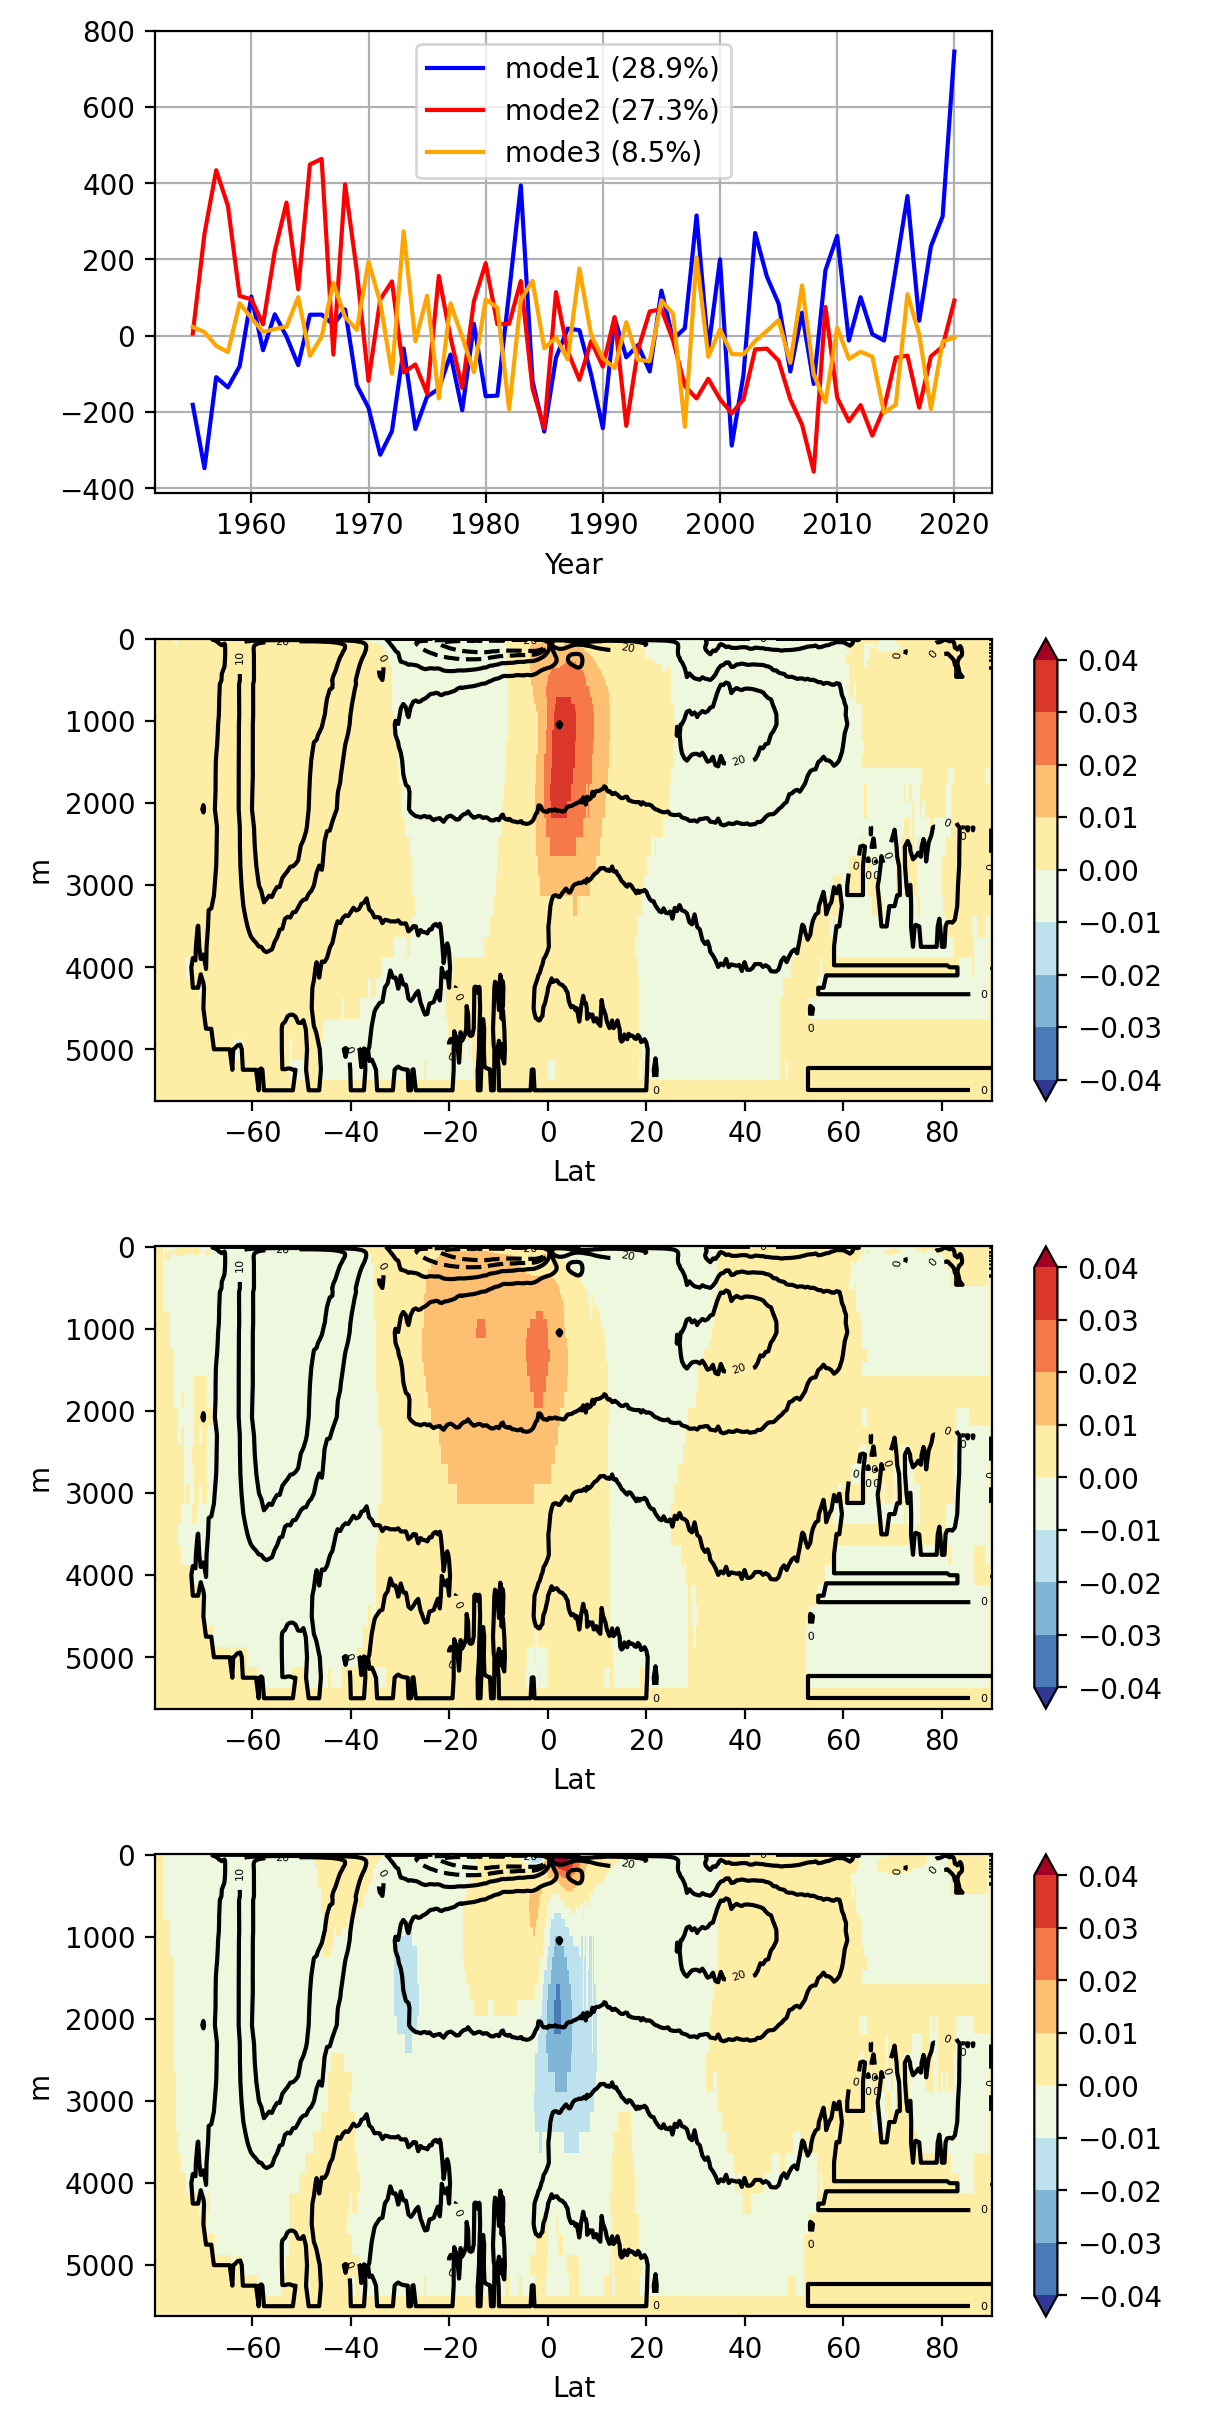

In [74]:
# Global MOC EOF plots

levels = np.linspace(-0.04,0.04,9)
ticklevels = np.linspace(-0.04,0.04,9)
contour_levels = [-20, -10, 0, 10, 20]

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=0).isel(moc_comp=0).isel(ens_ADA=0)
data_array=data_array.mean(dim='time')
data_array = data_array.rename({'lat_aux_grid': 'LAT'})
data_array['moc_z']=data_array['moc_z']/100 #cm -> m

glo_eof_lv['moc_z']=data_array['moc_z'] #cm -> m

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 12),
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

axes[0].plot(glo_eof_pct["year"], glo_eof_pct.sel(mode=1), color="blue", label="mode1 (28.9%)")
axes[0].plot(glo_eof_pct["year"], glo_eof_pct.sel(mode=2), color="red", label="mode2 (27.3%)")
axes[0].plot(glo_eof_pct["year"], glo_eof_pct.sel(mode=3), color="orange", label="mode3 (8.5%)")

axes[0].set_xlabel("Year")
axes[0].set_ylabel(" ")
axes[0].grid(True)
axes[0].legend()

# cmap2 = plt.get_cmap('RdBu_r')
cmap2 = plt.get_cmap('RdYlBu_r')

# mode 1 lv
plt1=glo_eof_lv.sel(mode=1).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[1], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[1], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1].invert_yaxis()
axes[1].set_xlabel("Lat")
axes[1].set_ylabel("m")
axes[1].set_title(" ")

# mode 2 lv
plt1=glo_eof_lv.sel(mode=2).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[2], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[2], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[2].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2].invert_yaxis()
axes[2].set_xlabel("Lat")
axes[2].set_ylabel("m")
axes[2].set_title(" ")

# mode 3 lv
plt1=glo_eof_lv.sel(mode=3).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[3], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[3], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[3].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3].invert_yaxis()
axes[3].set_xlabel("Lat")
axes[3].set_ylabel("m")
axes[3].set_title(" ")



# cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
# cbar1 = fig.colorbar(plt2, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('Sv')
# cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격



plt.show()

In [57]:
# Asian-Pacific MOC EOF

data_array=( cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=0).isel(moc_comp=0).isel(ens_ADA=0).groupby('time.year').mean(dim='time', skipna=True)
            - cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_ADA=0).groupby('time.year').mean(dim='time', skipna=True))
data_array = data_array.rename({'lat_aux_grid': 'LAT'})

ap_eofmodel = xe.single.EOF(n_modes=3, use_coslat=True)
ap_eofmodel.fit(data_array, dim="year")
ap_eofmodel.explained_variance_ratio()

ap_eof_lv = ap_eofmodel.components()
ap_eof_pct = ap_eofmodel.scores()
# components.sel(mode=1).plot()
# pct.plot()
ap_eofmodel.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 3)> Size: 24B
array([0.27998273, 0.25504863, 0.10629266])
Coordinates:
    ens_ADA         int64 8B 0
    moc_components  |S13 13B b'Eulerian Mean'
  * mode            (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-03-03 19:56:11
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [60]:
cfg_var_MOC.ADA_ds.moc_comp

<xarray.DataArray 'moc_comp' (moc_comp: 3)> Size: 24B
array([0, 1, 2])
Coordinates:
    moc_components  (moc_comp) |S384 1kB dask.array<chunksize=(3,), meta=np.ndarray>
Dimensions without coordinates: moc_comp

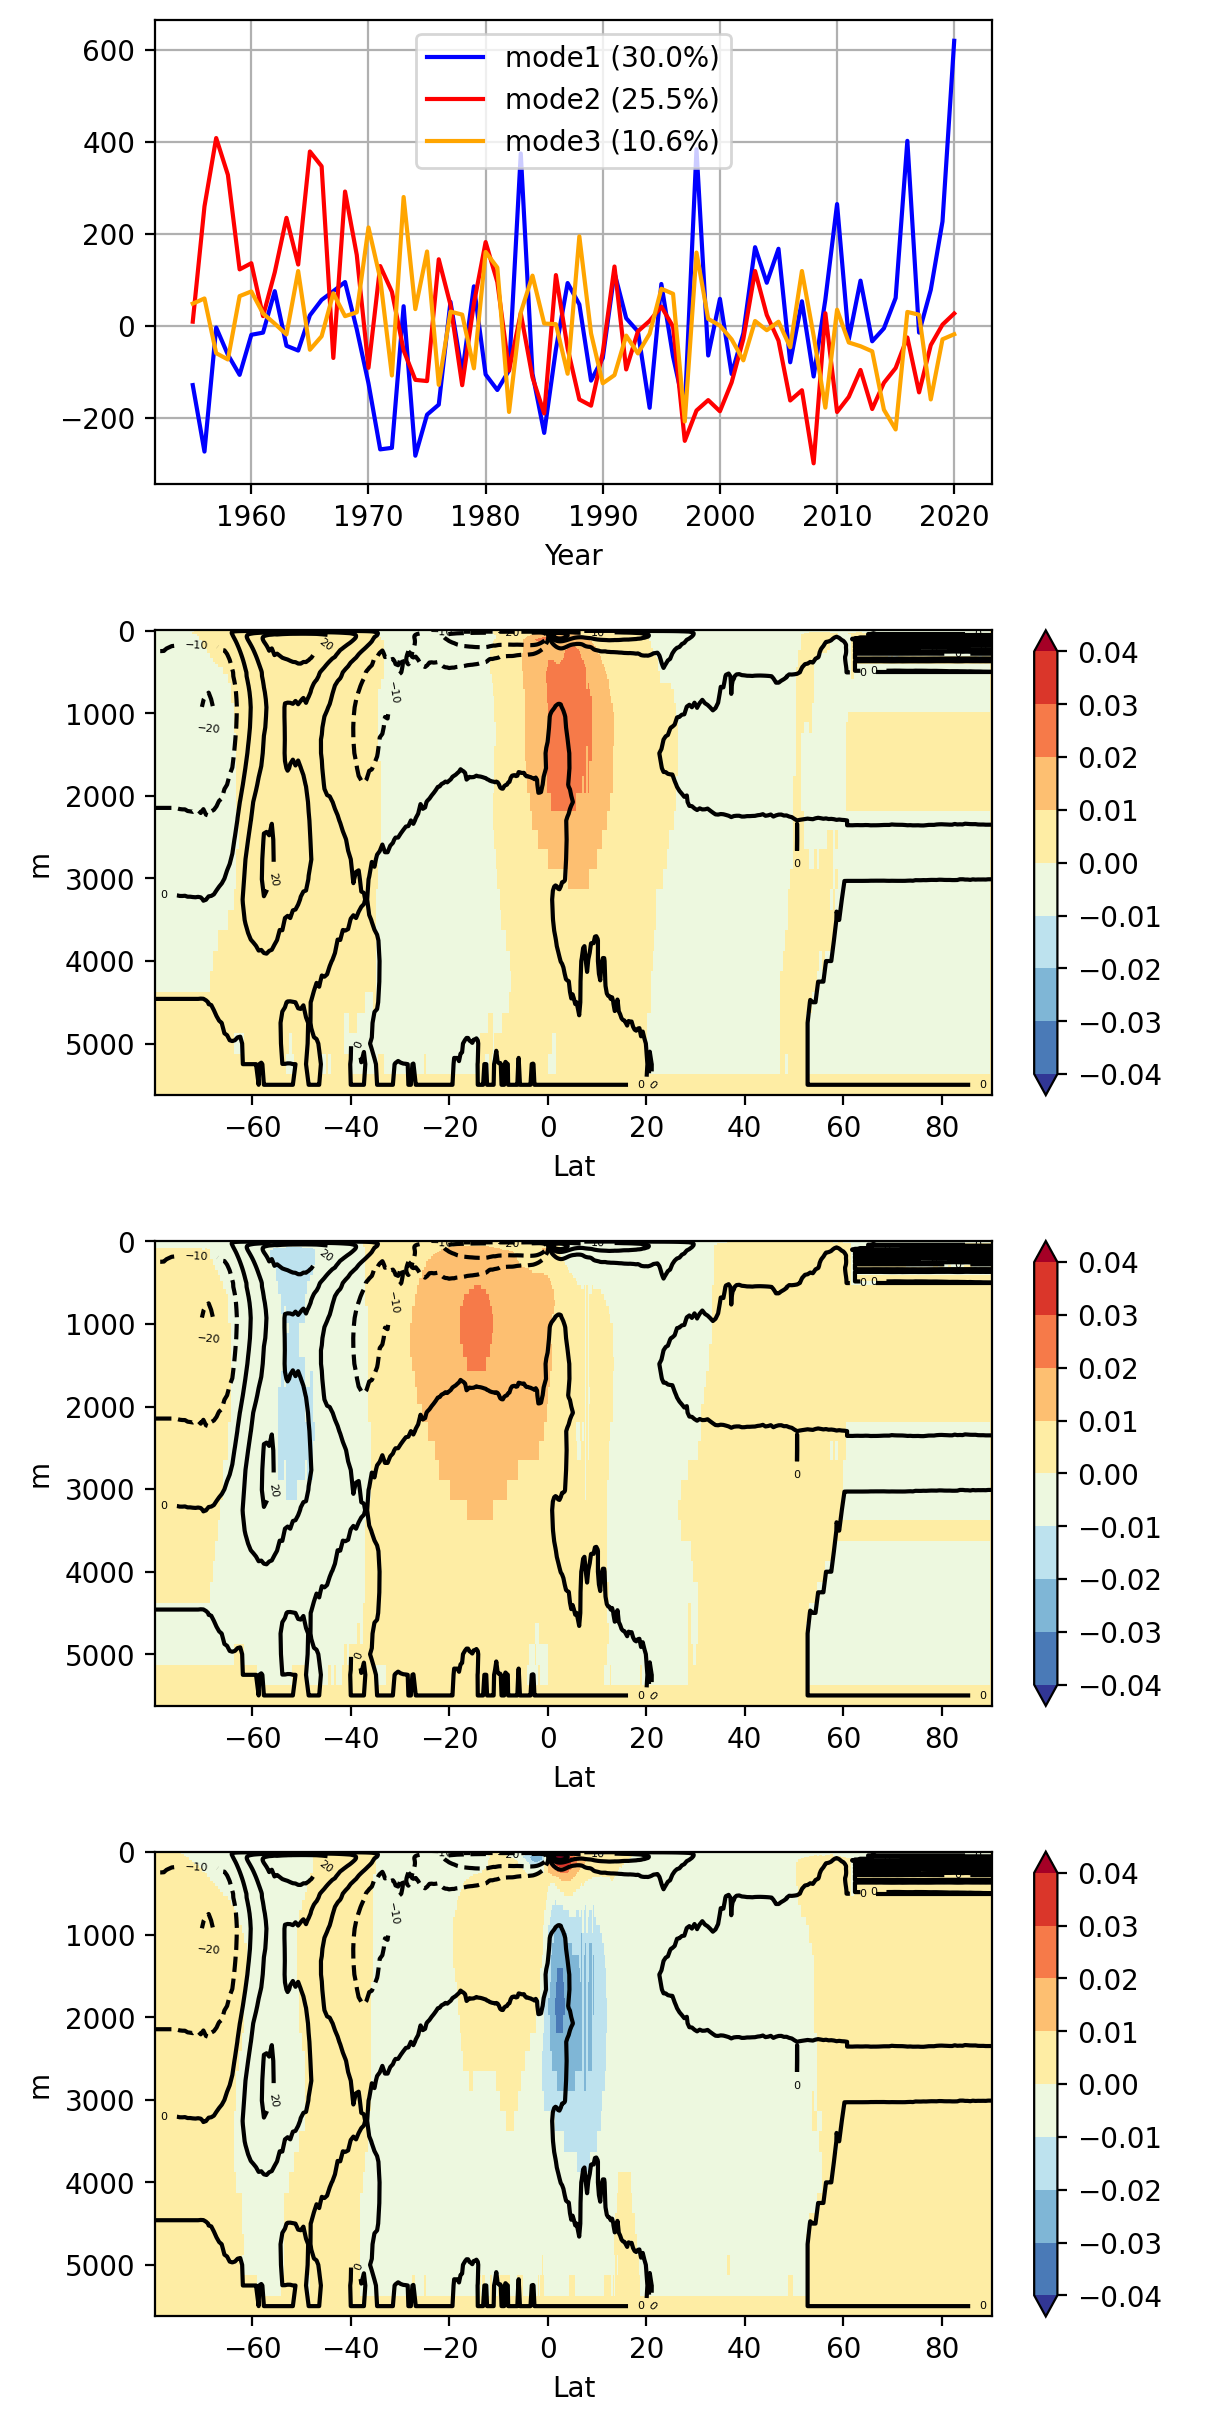

In [75]:
# Asian-Pacific MOC EOF plots

levels = np.linspace(-0.04,0.04,9)
ticklevels = np.linspace(-0.04,0.04,9)
contour_levels = [-20, -10, 0, 10, 20]

data_array=cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=0).isel(moc_comp=0).isel(ens_ADA=0) - cfg_var_MOC.ADA_ds['MOC'].isel(transport_reg=1).isel(moc_comp=0).isel(ens_ADA=0)
data_array=data_array.mean(dim='time')
data_array = data_array.rename({'lat_aux_grid': 'LAT'})
data_array['moc_z']=data_array['moc_z']/100 #cm -> m

ap_eof_lv['moc_z']=data_array['moc_z'] #cm -> m

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 12),
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

axes[0].plot(ap_eof_pct["year"], ap_eof_pct.sel(mode=1), color="blue", label="mode1 (30.0%)")
axes[0].plot(ap_eof_pct["year"], ap_eof_pct.sel(mode=2), color="red", label="mode2 (25.5%)")
axes[0].plot(ap_eof_pct["year"], ap_eof_pct.sel(mode=3), color="orange", label="mode3 (10.6%)")

axes[0].set_xlabel("Year")
axes[0].set_ylabel(" ")
axes[0].grid(True)
axes[0].legend()

# cmap2 = plt.get_cmap('RdBu_r')
cmap2 = plt.get_cmap('RdYlBu_r')

# mode 1 lv
plt1=ap_eof_lv.sel(mode=1).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[1], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[1], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1].invert_yaxis()
axes[1].set_xlabel("Lat")
axes[1].set_ylabel("m")
axes[1].set_title(" ")

# mode 2 lv
plt1=ap_eof_lv.sel(mode=2).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[2], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[2], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[2].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2].invert_yaxis()
axes[2].set_xlabel("Lat")
axes[2].set_ylabel("m")
axes[2].set_title(" ")

# mode 3 lv
plt1=ap_eof_lv.sel(mode=3).plot.pcolormesh(x='LAT', y='moc_z', ax=axes[3], levels=levels,
                                        cmap= cmap2, add_colorbar=True, extend='both', vmin=-0.04, vmax=0.04,
                                       cbar_kwargs={"label": " ", 'ticks': ticklevels})
cs = data_array.plot.contour(
    x='LAT', y='moc_z', ax=axes[3], colors='black', linewidths=1.5, levels=contour_levels,
    add_colorbar=False
)
axes[3].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3].invert_yaxis()
axes[3].set_xlabel("Lat")
axes[3].set_ylabel("m")
axes[3].set_title(" ")



# cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
# cbar1 = fig.colorbar(plt2, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('Sv')
# cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격



plt.show()

# read SST for Nino3.4, ATL3, AMO

In [76]:
cfg_var_SST=CESM2_config()
cfg_var_SST.year_s=1955
cfg_var_SST.year_e=2020
cfg_var_SST.setvar('SST')
cfg_var_SST.list()

In [82]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_SST.var, 'sst']
def process_coords_SST(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds= ds.sel(time=slice(sd, ed)).isel(lev=slice(1, 11))
        return ds
    else:
        return ds.set_coords(coord_vars)


start_date = cftime.DatetimeNoLeap(cfg_var_SST.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_SST.year_e+1, 1, 1)

In [135]:
#Read ADA dataset
start_time = time.time()

#SST
cfg_var_SST.ADA_path_load(cfg_var_SST.var)
cfg_var_SST.ADA_ds = xr.open_mfdataset(cfg_var_SST.ADA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_SST.ADA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_SST(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      


cfg_var_SST.ADA_ds = cfg_var_SST.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_SST.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_SST.ADA_ds.time))
cfg_var_SST.ADA_ds = cfg_var_SST.ADA_ds.assign_coords(time=new_time)
cfg_var_SST.ADA_ds['SST'] = cfg_var_SST.ADA_ds['SST'].where(cfg_var_SST.ADA_ds['SST'] != 0)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))

elasped time for reading ADA: 3.7239627838134766


# get Nino 3.4, ATL3, AMO, IPO

In [159]:
# Nino3.4

ADA_nino34 = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= -5) 
    & (cfg_var_SST.ADA_ds['lat'] <= 5)
    & (cfg_var_SST.ADA_ds['lon'] >= 190)
    & (cfg_var_SST.ADA_ds['lon'] <= 240),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_nino34.lat))
weights_2d = weights_lat.broadcast_like(ADA_nino34['SST'])
ADA_nino34 = ADA_nino34.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_nino34_yearly = ADA_nino34.groupby('time.year').mean(dim='time', skipna=True)

# corr_nino34_ap_eof_mode1=xr.corr(ADA_nino34_yearly['SST'].sel(ens_ADA=0), 
#                      ap_eof_pct.sel(mode=1), dim='year').compute()

#ATL3

ADA_ATL3 = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= -3) 
    & (cfg_var_SST.ADA_ds['lat'] <= 3)
    & (cfg_var_SST.ADA_ds['lon'] >= 340)
    & (cfg_var_SST.ADA_ds['lon'] <= 360),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_ATL3.lat))
weights_2d = weights_lat.broadcast_like(ADA_ATL3['SST'])
ADA_ATL3 = ADA_ATL3.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_ATL3_yearly = ADA_ATL3.groupby('time.year').mean(dim='time', skipna=True)

# AMO
ADA_AMO_ATL = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= 0) 
    & (cfg_var_SST.ADA_ds['lat'] <= 60)
    & (cfg_var_SST.ADA_ds['lon'] >= 280)
    & (cfg_var_SST.ADA_ds['lon'] <= 360),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_AMO_ATL.lat))
weights_2d = weights_lat.broadcast_like(ADA_AMO_ATL['SST'])
ADA_AMO_ATL = ADA_AMO_ATL.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_AMO_ATL_yearly = ADA_AMO_ATL.groupby('time.year').mean(dim='time', skipna=True)

#GLO
ADA_AMO_GLO = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= -60) 
    & (cfg_var_SST.ADA_ds['lat'] <= 60)
    & (cfg_var_SST.ADA_ds['lon'] >= 0)
    & (cfg_var_SST.ADA_ds['lon'] <= 360),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_AMO_GLO.lat))
weights_2d = weights_lat.broadcast_like(ADA_AMO_GLO['SST'].sel(ens_ADA=0).isel(time=0))
ADA_AMO_GLO = ADA_AMO_GLO.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_AMO_GLO_yearly = ADA_AMO_GLO.groupby('time.year').mean(dim='time', skipna=True)

ADA_AMO = ADA_AMO_ATL - ADA_AMO_GLO
ADA_AMO_yearly = ADA_AMO.groupby('time.year').mean(dim='time', skipna=True)

# IPO
ADA_IPO_r1 = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= 25) 
    & (cfg_var_SST.ADA_ds['lat'] <= 45)
    & (cfg_var_SST.ADA_ds['lon'] >= 140)
    & (cfg_var_SST.ADA_ds['lon'] <= 215),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_IPO_r1.lat))
weights_2d = weights_lat.broadcast_like(ADA_IPO_r1['SST'])
ADA_IPO_r1 = ADA_IPO_r1.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_IPO_r1_yearly = ADA_IPO_r1.groupby('time.year').mean(dim='time', skipna=True)

ADA_IPO_r2 = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= -15) 
    & (cfg_var_SST.ADA_ds['lat'] <= 10)
    & (cfg_var_SST.ADA_ds['lon'] >= 170)
    & (cfg_var_SST.ADA_ds['lon'] <= 270),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_IPO_r2.lat))
weights_2d = weights_lat.broadcast_like(ADA_IPO_r2['SST'])
ADA_IPO_r2 = ADA_IPO_r2.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_IPO_r2_yearly = ADA_IPO_r2.groupby('time.year').mean(dim='time', skipna=True)

ADA_IPO_r3 = cfg_var_SST.ADA_ds.where(
    (cfg_var_SST.ADA_ds['lat'] >= -50) 
    & (cfg_var_SST.ADA_ds['lat'] <= -15)
    & (cfg_var_SST.ADA_ds['lon'] >= 150)
    & (cfg_var_SST.ADA_ds['lon'] <= 200),
    drop=True
)
weights_lat = np.cos(np.deg2rad(ADA_IPO_r3.lat))
weights_2d = weights_lat.broadcast_like(ADA_IPO_r3['SST'])
ADA_IPO_r3 = ADA_IPO_r3.weighted(weights_2d).mean(dim=['lat','lon'], skipna=True)
ADA_IPO_r3_yearly = ADA_IPO_r3.groupby('time.year').mean(dim='time', skipna=True)

ADA_IPO = ADA_IPO_r2 - (ADA_IPO_r1 + ADA_IPO_r3)/2
ADA_IPO_yearly = ADA_IPO.groupby('time.year').mean(dim='time', skipna=True)

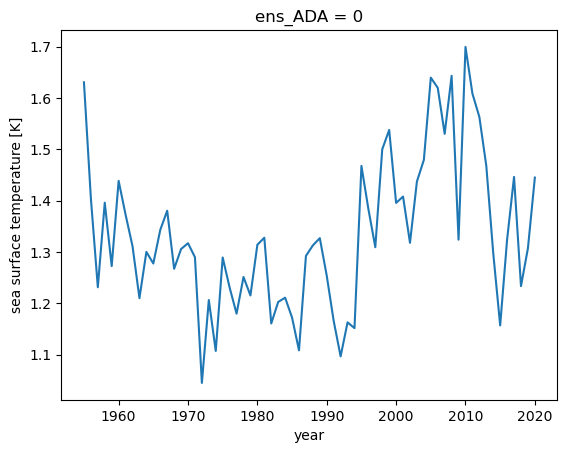

In [138]:
# ADA_AMO_GLO_yearly['SST'].plot()

# ADA_AMO_GLO = cfg_var_SST.ADA_ds.where(
#     (cfg_var_SST.ADA_ds['lat'] >= -60) 
#     & (cfg_var_SST.ADA_ds['lat'] <= 60)
#     & (cfg_var_SST.ADA_ds['lon'] >= 0)
#     & (cfg_var_SST.ADA_ds['lon'] <= 360),
#     drop=True
# )

# ADA_AMO_GLO.sel(ens_ADA=0).isel(time=0)['SST'].plot.pcolormesh(
#     x='lon',
#     y='lat',
#     cmap='viridis'
# )
# plt.show()

ADA_AMO_yearly['SST'].sel(ens_ADA=0).plot()

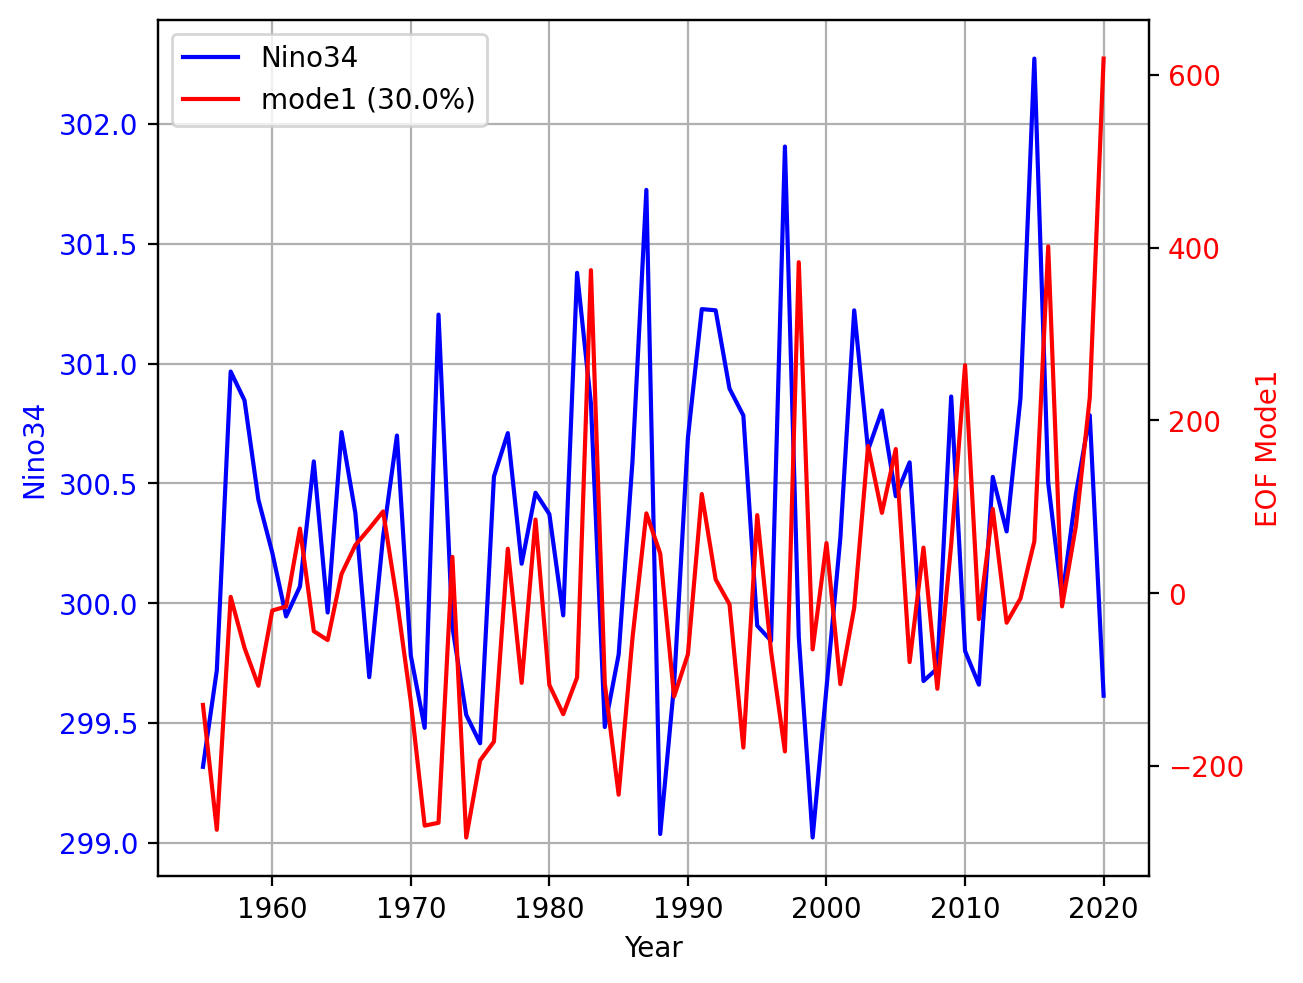

<xarray.DataArray (lead: 11)> Size: 88B
dask.array<concatenate, shape=(11,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    ens_ADA         int64 8B 0
    moc_components  |S13 13B b'Eulerian Mean'
    mode            int64 8B 1
  * lead            (lead) int64 88B -5 -4 -3 -2 -1 0 1 2 3 4 5
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

In [139]:
fig, ax1 = plt.subplots(dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)

line1 = ax1.plot(
    ap_eof_pct["year"],
    ADA_nino34_yearly['SST'].sel(ens_ADA=0),
    color="blue",
    label="Nino34"
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Nino34", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()

line2 = ax2.plot(
    ap_eof_pct["year"],
    ap_eof_pct.sel(mode=1),
    color="red",
    label="mode1 (30.0%)"
)

ax2.set_ylabel("EOF Mode1", color="red")
ax2.tick_params(axis='y', labelcolor="red")

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.show()

corr_nino34_ap_eof_mode1

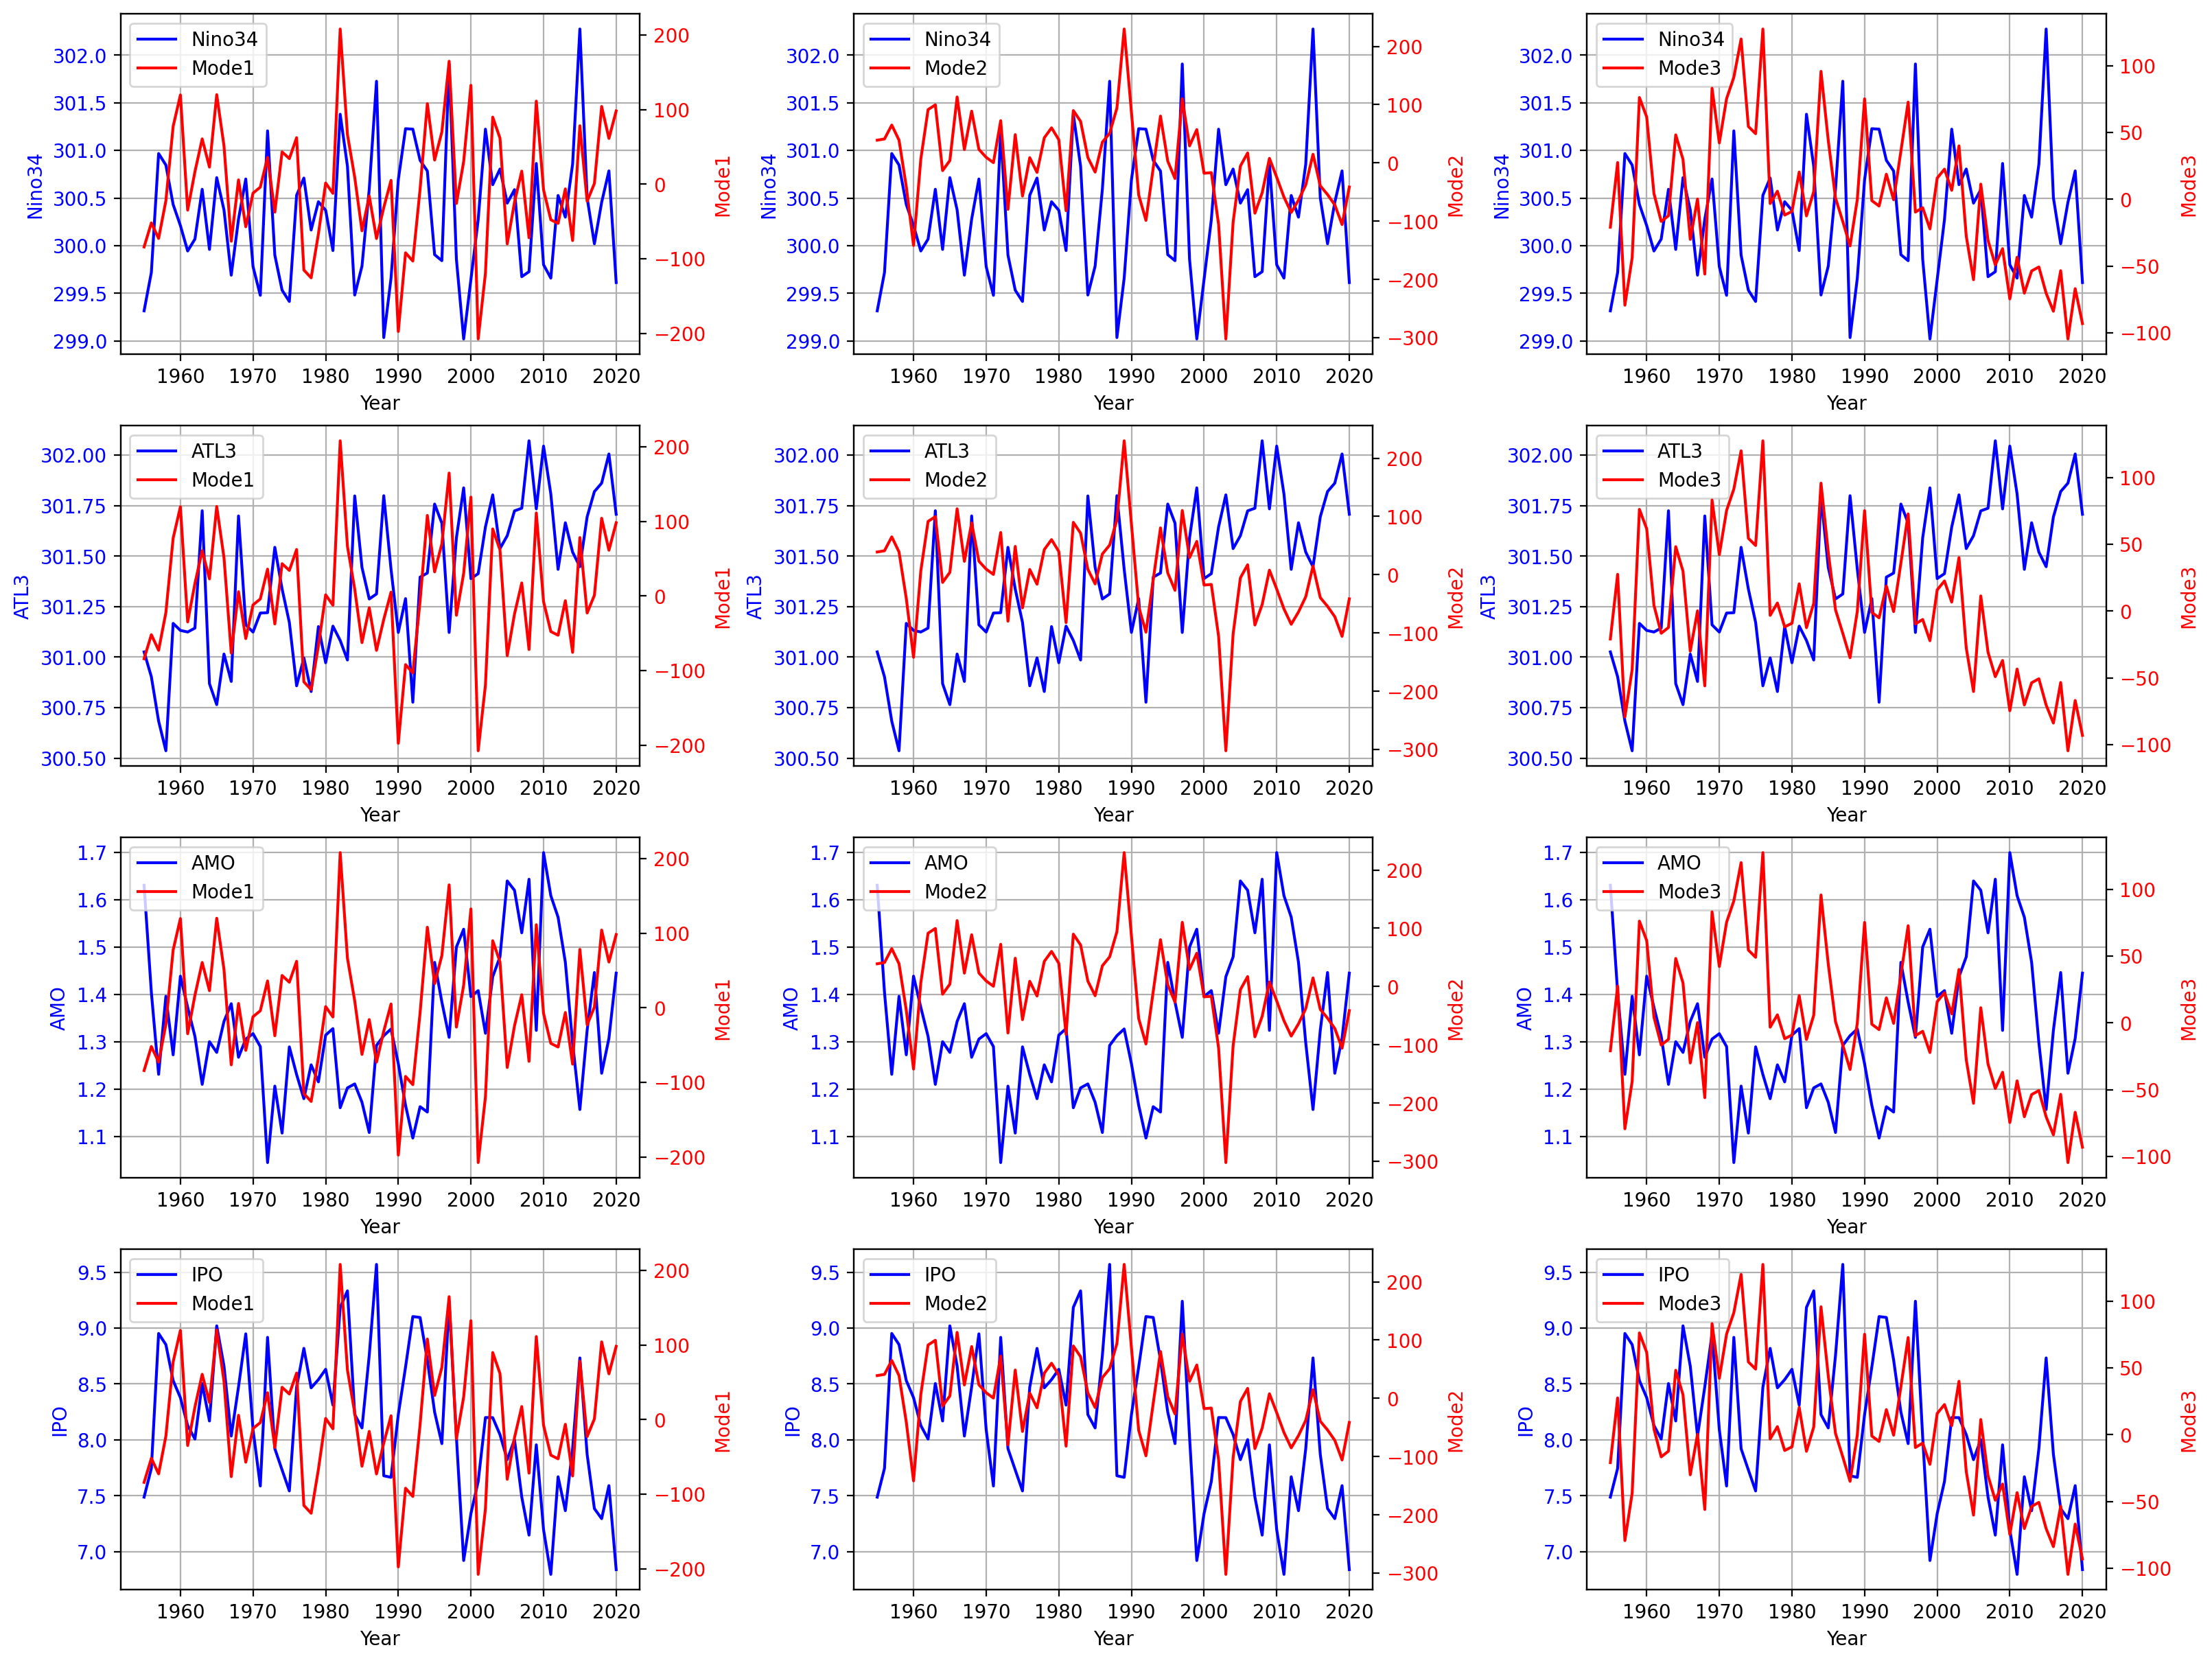

In [161]:
# AMOC line plots

# 1) Prepare your time and data arrays (example)
time_year = eof_pct["year"]  # x-axis for both lines

# Indices: Nino34, ATL3, AMO
ts_names = ["Nino34", "ATL3", "AMO", "IPO"]
ts_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0), 
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0), 
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# Modes: mode1, mode2, mode3
mode_names = ["Mode1", "Mode2", "Mode3"]  # adjust labels as needed
mode_data = [
    eof_pct.sel(mode=1),
    eof_pct.sel(mode=2),
    eof_pct.sel(mode=3)
]

# 2) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 3) Double loop: i=0..2 for the row (index), j=0..2 for the column (mode)
for i in range(4):
    for j in range(3):
        ax1 = axs[i, j]
        
        # LEFT y-axis (blue): index timeseries
        line1 = ax1.plot(
            time_year,
            ts_data[i],
            color="blue",
            label=ts_names[i]
        )
        ax1.set_ylabel(ts_names[i], color="blue")
        ax1.tick_params(axis='y', labelcolor="blue")
        ax1.set_xlabel("Year")
        ax1.grid(True)

        # RIGHT y-axis (red): EOF mode timeseries
        ax2 = ax1.twinx()
        line2 = ax2.plot(
            time_year,
            mode_data[j],
            color="red",
            label=mode_names[j]
        )
        ax2.set_ylabel(mode_names[j], color="red")
        ax2.tick_params(axis='y', labelcolor="red")

        # Combine legend entries from both lines
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc="upper left")

plt.show()

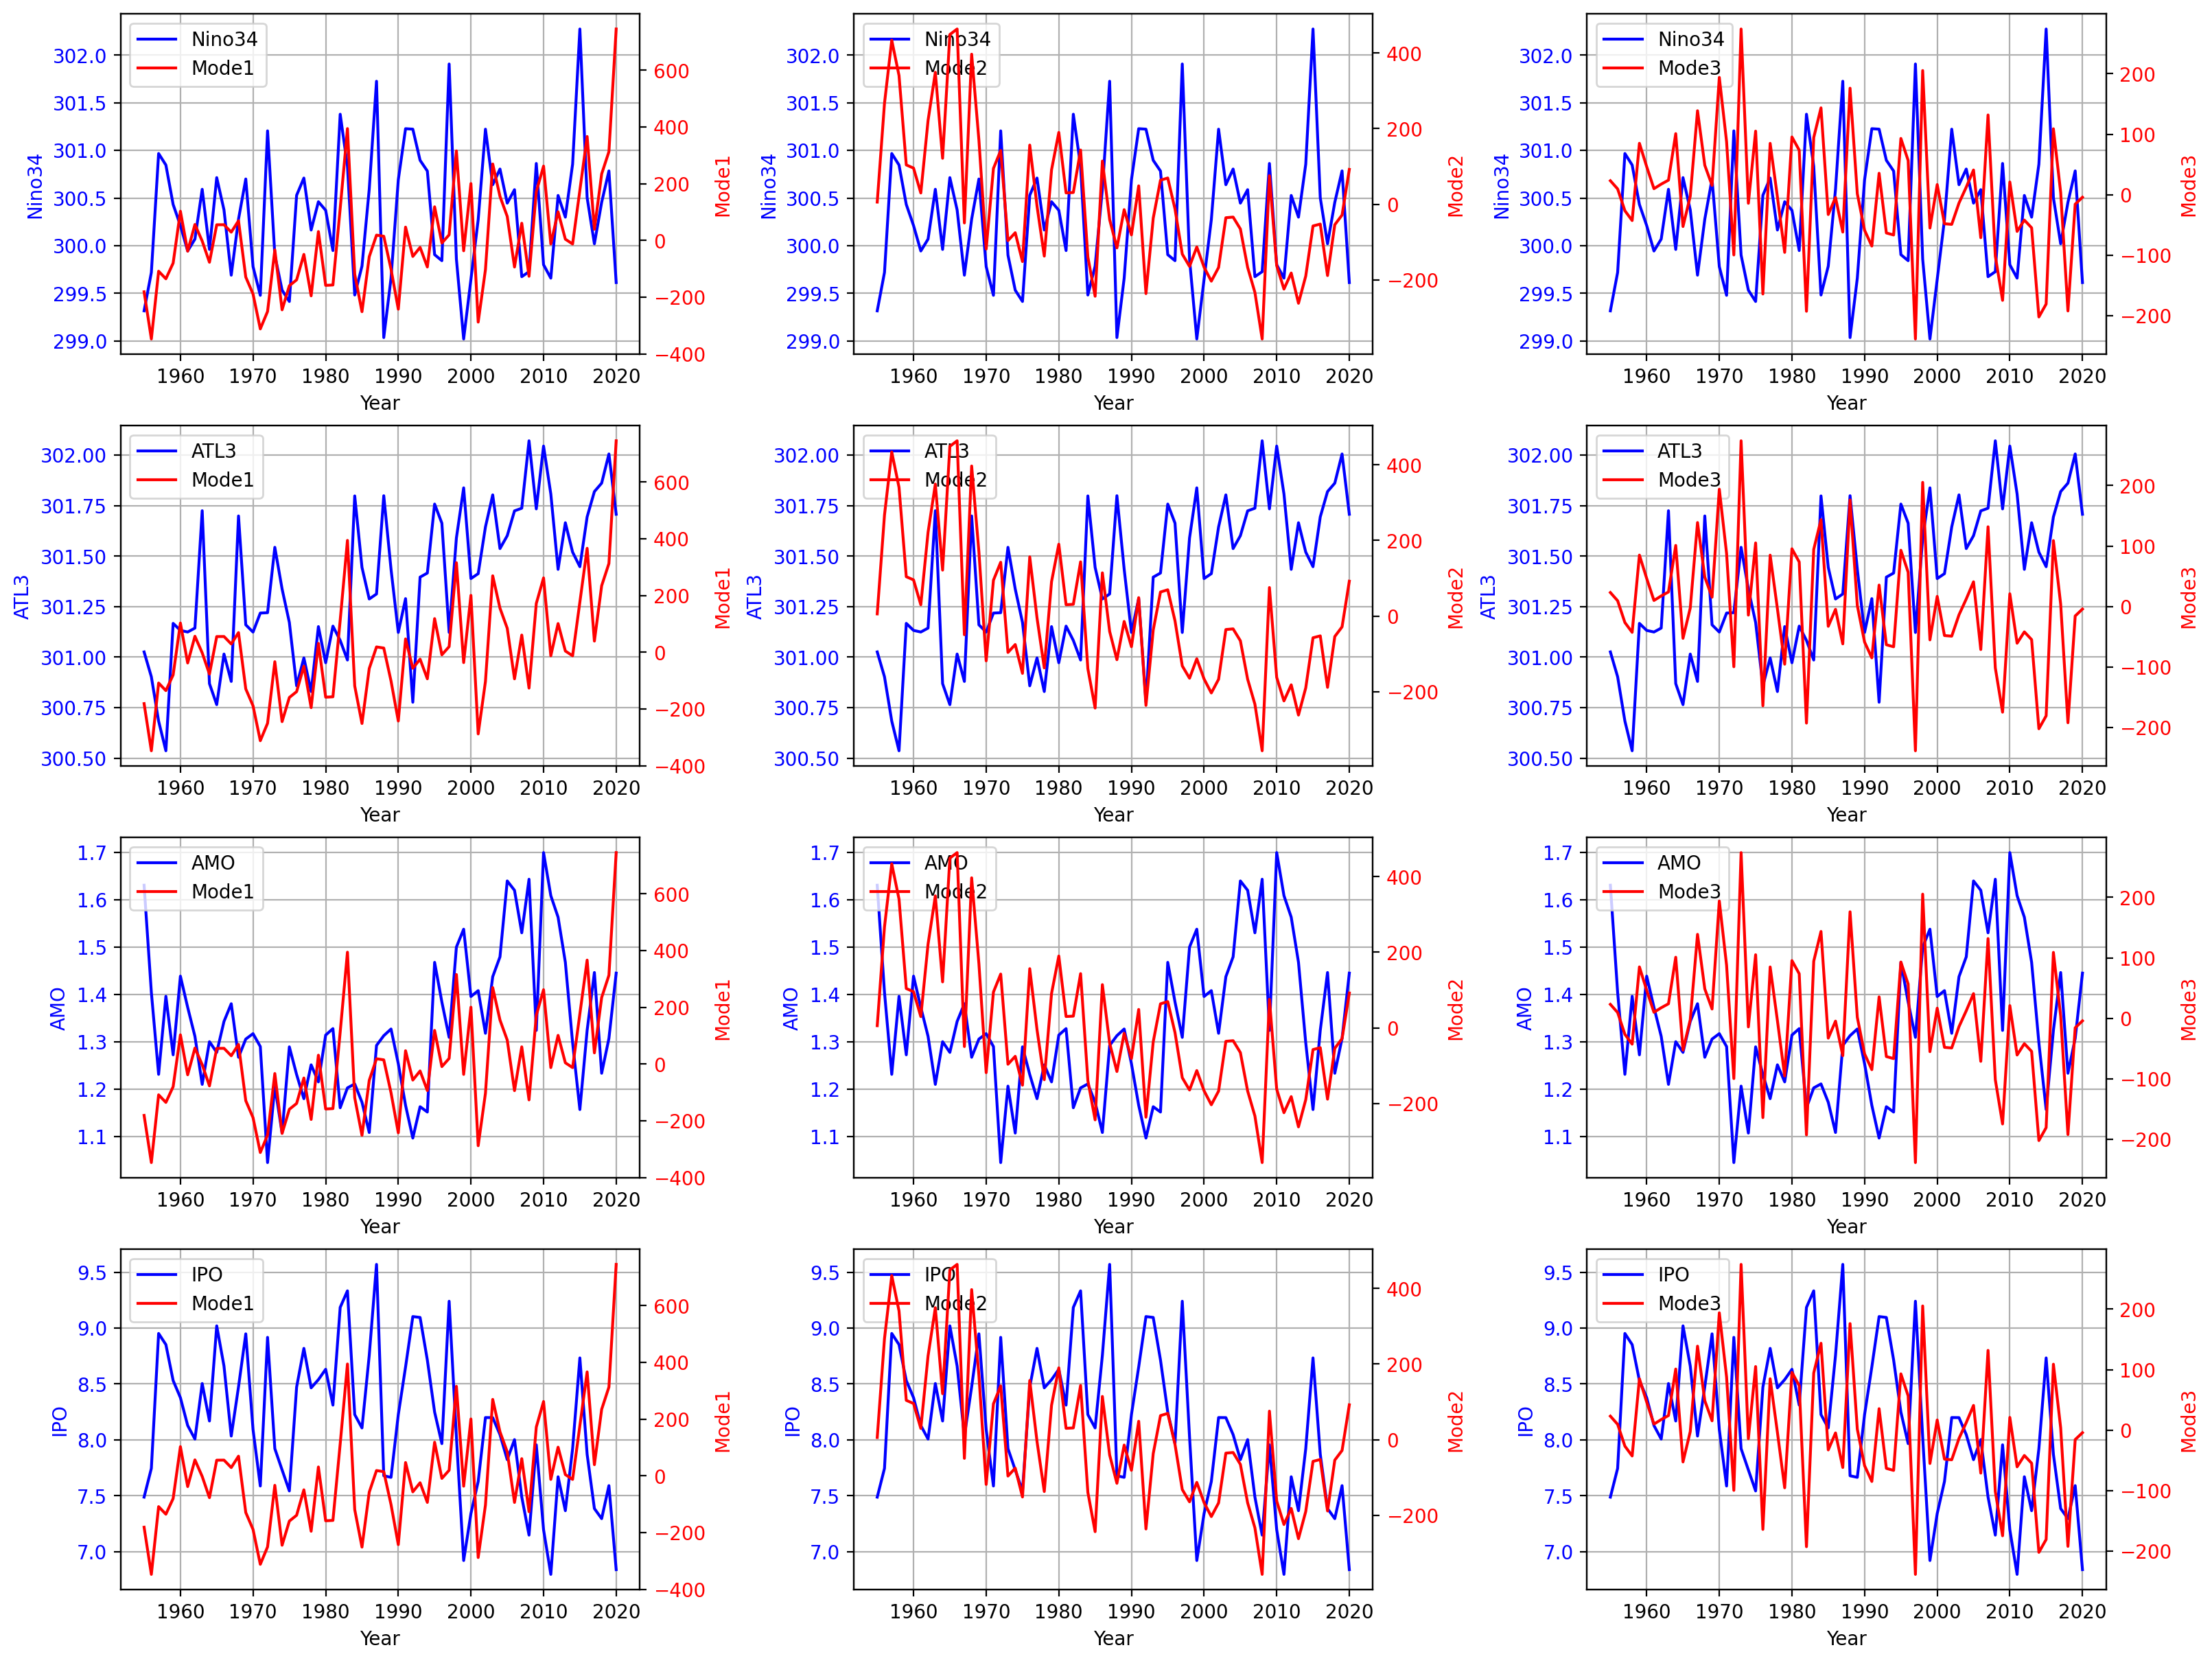

In [162]:
# GLO MOC line plots

# 1) Prepare your time and data arrays (example)
time_year = glo_eof_pct["year"]  # x-axis for both lines

# Indices: Nino34, ATL3, AMO
ts_names = ["Nino34", "ATL3", "AMO", "IPO"]
ts_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0), 
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0), 
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# Modes: mode1, mode2, mode3
mode_names = ["Mode1", "Mode2", "Mode3"]  # adjust labels as needed
mode_data = [
    glo_eof_pct.sel(mode=1),
    glo_eof_pct.sel(mode=2),
    glo_eof_pct.sel(mode=3)
]

# 2) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 3) Double loop: i=0..2 for the row (index), j=0..2 for the column (mode)
for i in range(4):
    for j in range(3):
        ax1 = axs[i, j]
        
        # LEFT y-axis (blue): index timeseries
        line1 = ax1.plot(
            time_year,
            ts_data[i],
            color="blue",
            label=ts_names[i]
        )
        ax1.set_ylabel(ts_names[i], color="blue")
        ax1.tick_params(axis='y', labelcolor="blue")
        ax1.set_xlabel("Year")
        ax1.grid(True)

        # RIGHT y-axis (red): EOF mode timeseries
        ax2 = ax1.twinx()
        line2 = ax2.plot(
            time_year,
            mode_data[j],
            color="red",
            label=mode_names[j]
        )
        ax2.set_ylabel(mode_names[j], color="red")
        ax2.tick_params(axis='y', labelcolor="red")

        # Combine legend entries from both lines
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc="upper left")

plt.show()

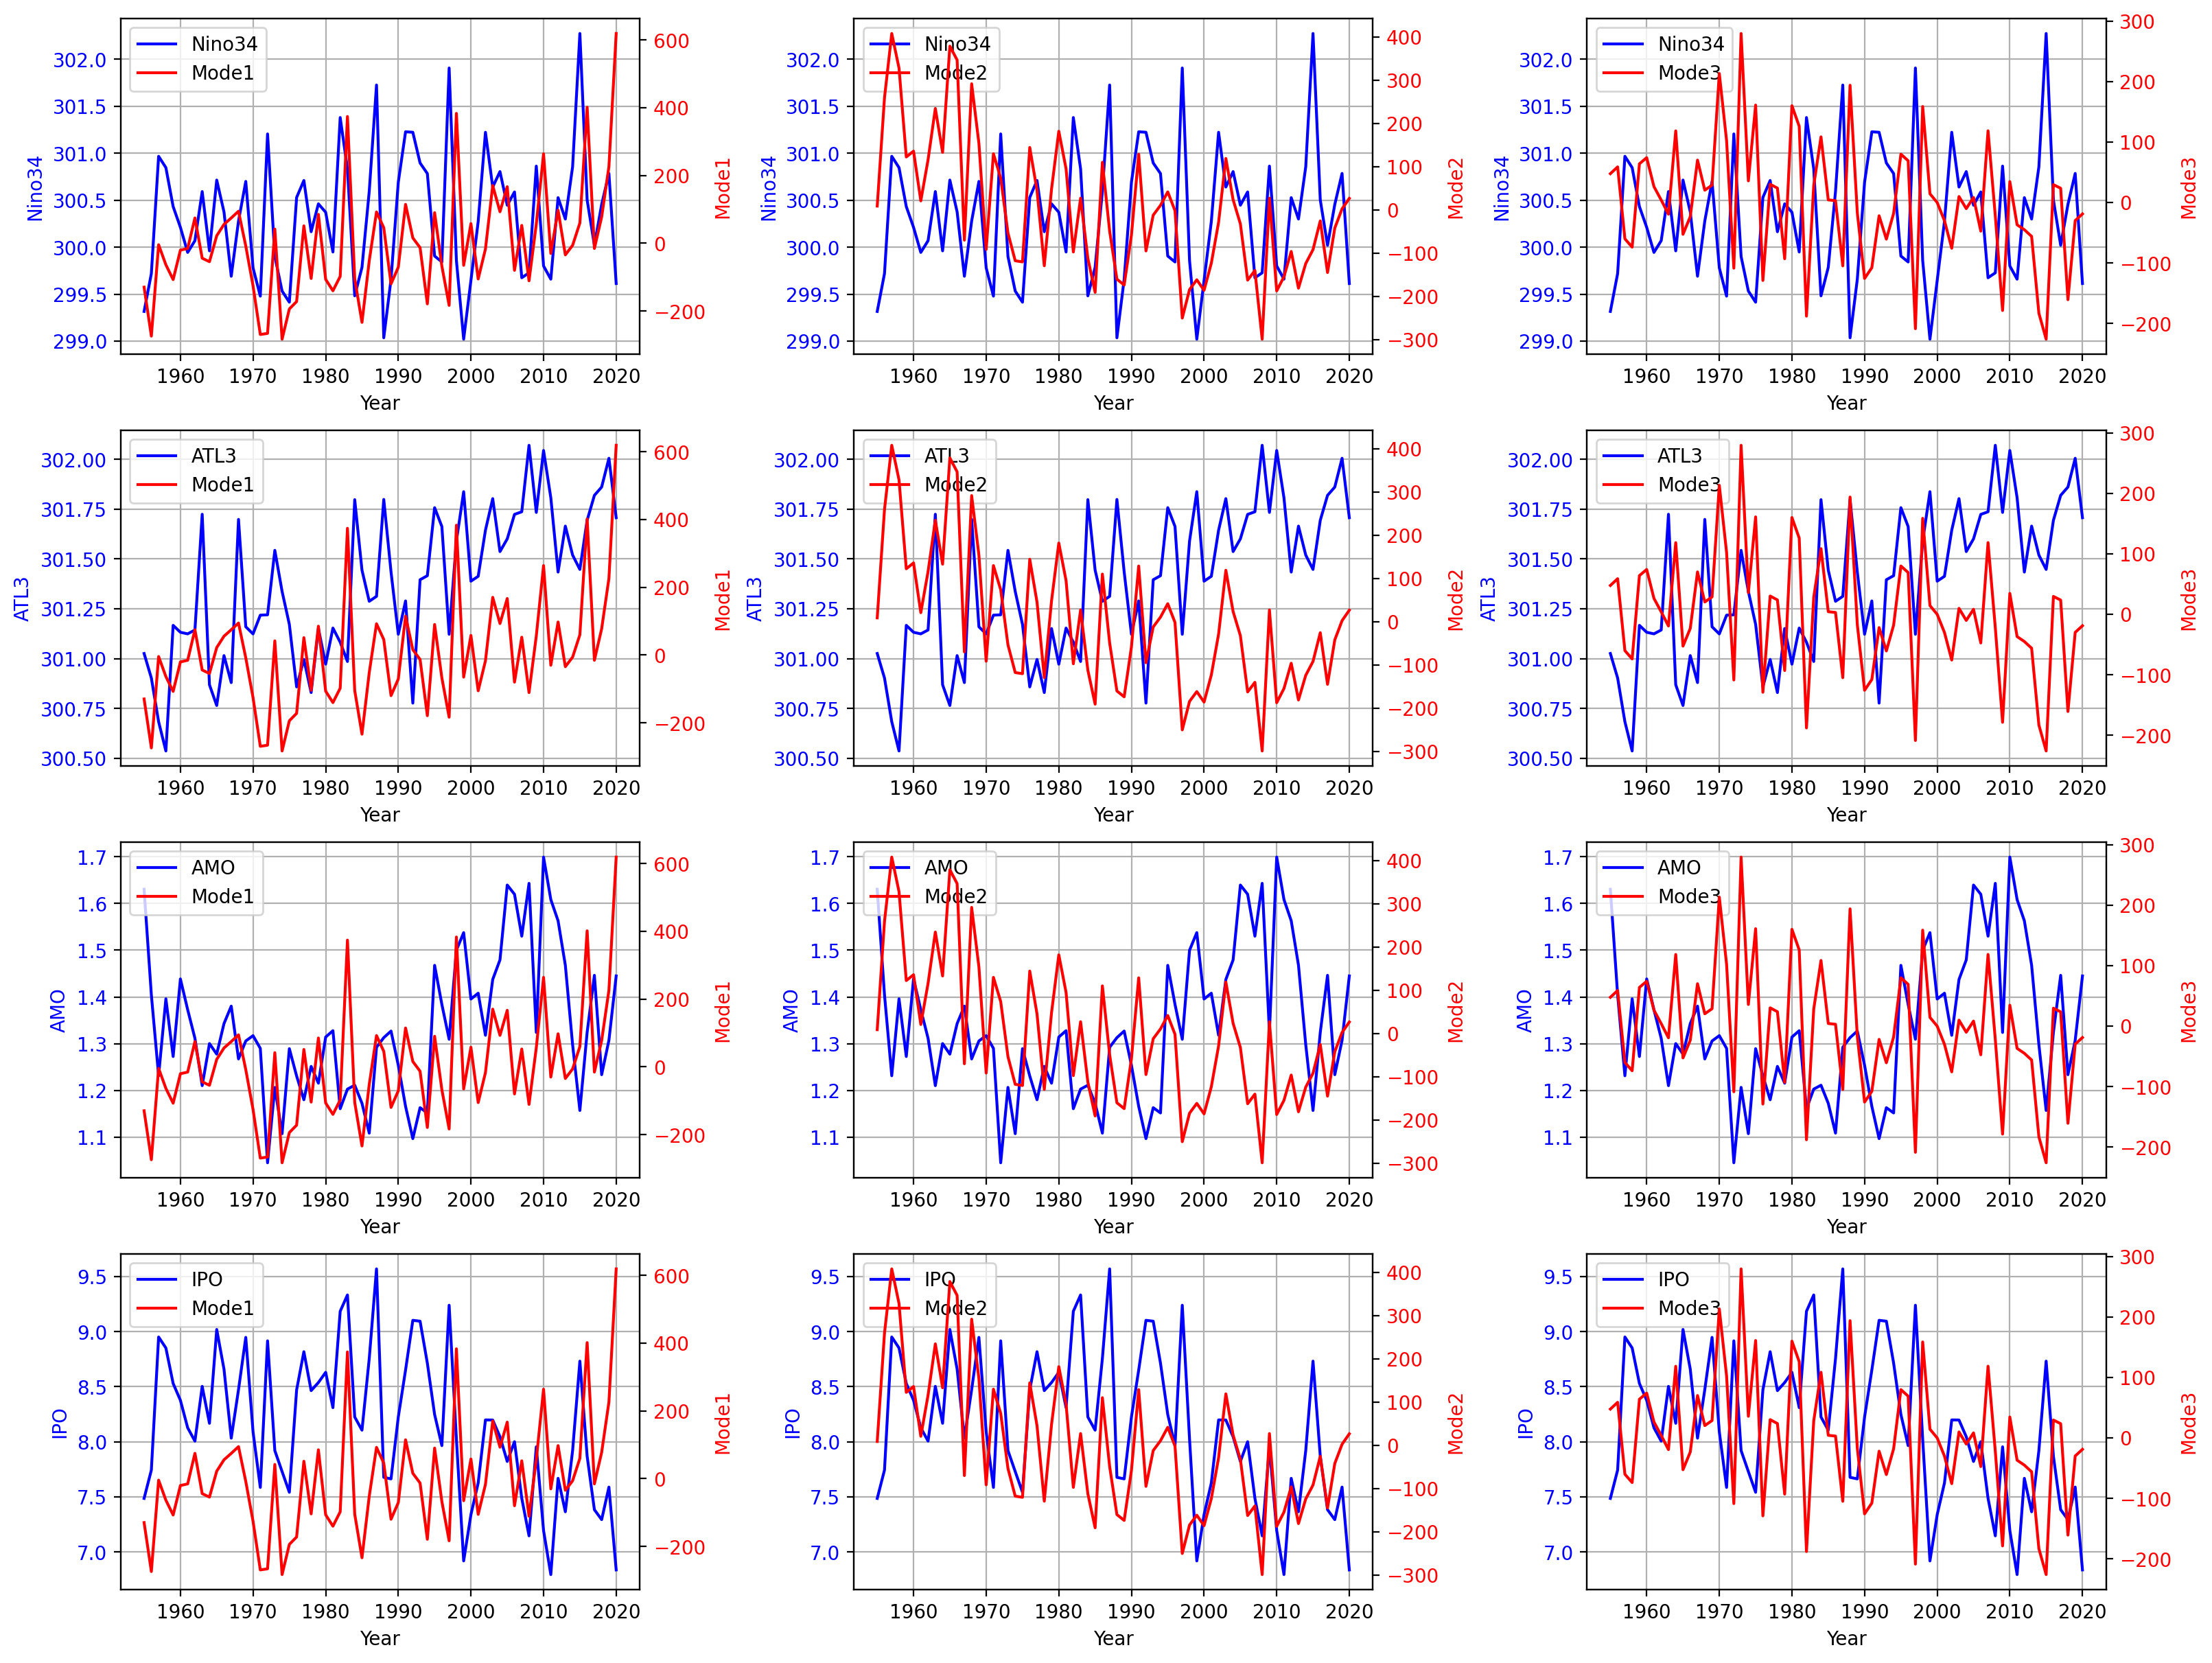

In [163]:
# AP MOC line plots

# 1) Prepare your time and data arrays (example)
time_year = ap_eof_pct["year"]  # x-axis for both lines

# Indices: Nino34, ATL3, AMO
ts_names = ["Nino34", "ATL3", "AMO", "IPO"]
ts_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0), 
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0), 
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# Modes: mode1, mode2, mode3
mode_names = ["Mode1", "Mode2", "Mode3"]  # adjust labels as needed
mode_data = [
    ap_eof_pct.sel(mode=1),
    ap_eof_pct.sel(mode=2),
    ap_eof_pct.sel(mode=3)
]

# 2) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 3) Double loop: i=0..2 for the row (index), j=0..2 for the column (mode)
for i in range(4):
    for j in range(3):
        ax1 = axs[i, j]
        
        # LEFT y-axis (blue): index timeseries
        line1 = ax1.plot(
            time_year,
            ts_data[i],
            color="blue",
            label=ts_names[i]
        )
        ax1.set_ylabel(ts_names[i], color="blue")
        ax1.tick_params(axis='y', labelcolor="blue")
        ax1.set_xlabel("Year")
        ax1.grid(True)

        # RIGHT y-axis (red): EOF mode timeseries
        ax2 = ax1.twinx()
        line2 = ax2.plot(
            time_year,
            mode_data[j],
            color="red",
            label=mode_names[j]
        )
        ax2.set_ylabel(mode_names[j], color="red")
        ax2.tick_params(axis='y', labelcolor="red")

        # Combine legend entries from both lines
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc="upper left")

plt.show()

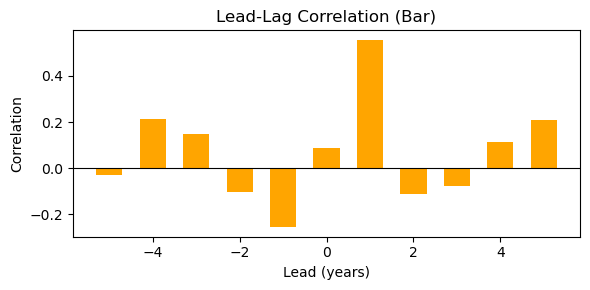

In [142]:
import xarray as xr
import numpy as np

x = ADA_nino34_yearly['SST'].sel(ens_ADA=0)
y = ap_eof_pct.sel(mode=1)

leads = range(-5, 6)  # from -5 to +5
corr_list = []

for lead in leads:
    if lead > 0:
        x_shifted = x.shift(year=lead)
        c = xr.corr(x_shifted, y, dim="year")
    elif lead < 0:
        y_shifted = y.shift(year=-lead)
        c = xr.corr(x, y_shifted, dim="year")
    else:
        c = xr.corr(x, y, dim="year")
    corr_list.append(c)

corr_nino34_ap_eof_mode1 = xr.concat(corr_list, dim="lead")
corr_nino34_ap_eof_mode1["lead"] = list(leads)

fig, ax_bar = plt.subplots(nrows=1, figsize=(6,3), sharex=True)
# fig, (ax_line, ax_bar) = plt.subplots(nrows=1, figsize=(6,3), sharex=True)

# # Line plot
# ax_line.plot(corr_nino34_ap_eof_mode1['lead'], corr_nino34_ap_eof_mode1, marker='o', color='blue')
# ax_line.axhline(0, color='black', linewidth=0.8)
# ax_line.set_ylabel("Correlation")
# ax_line.set_title("Lead-Lag Correlation (Line)")

# Bar plot
ax_bar.bar(corr_nino34_ap_eof_mode1['lead'].values, corr_nino34_ap_eof_mode1.values, color='orange', width=0.6)
ax_bar.axhline(0, color='black', linewidth=0.8)
ax_bar.set_xlabel("Lead (years)")
ax_bar.set_ylabel("Correlation")
ax_bar.set_title("Lead-Lag Correlation (Bar)")

plt.tight_layout()
plt.show()

In [108]:
corr_nino34_ap_eof_mode1.sel(lead=1).values

array(0.55732475)

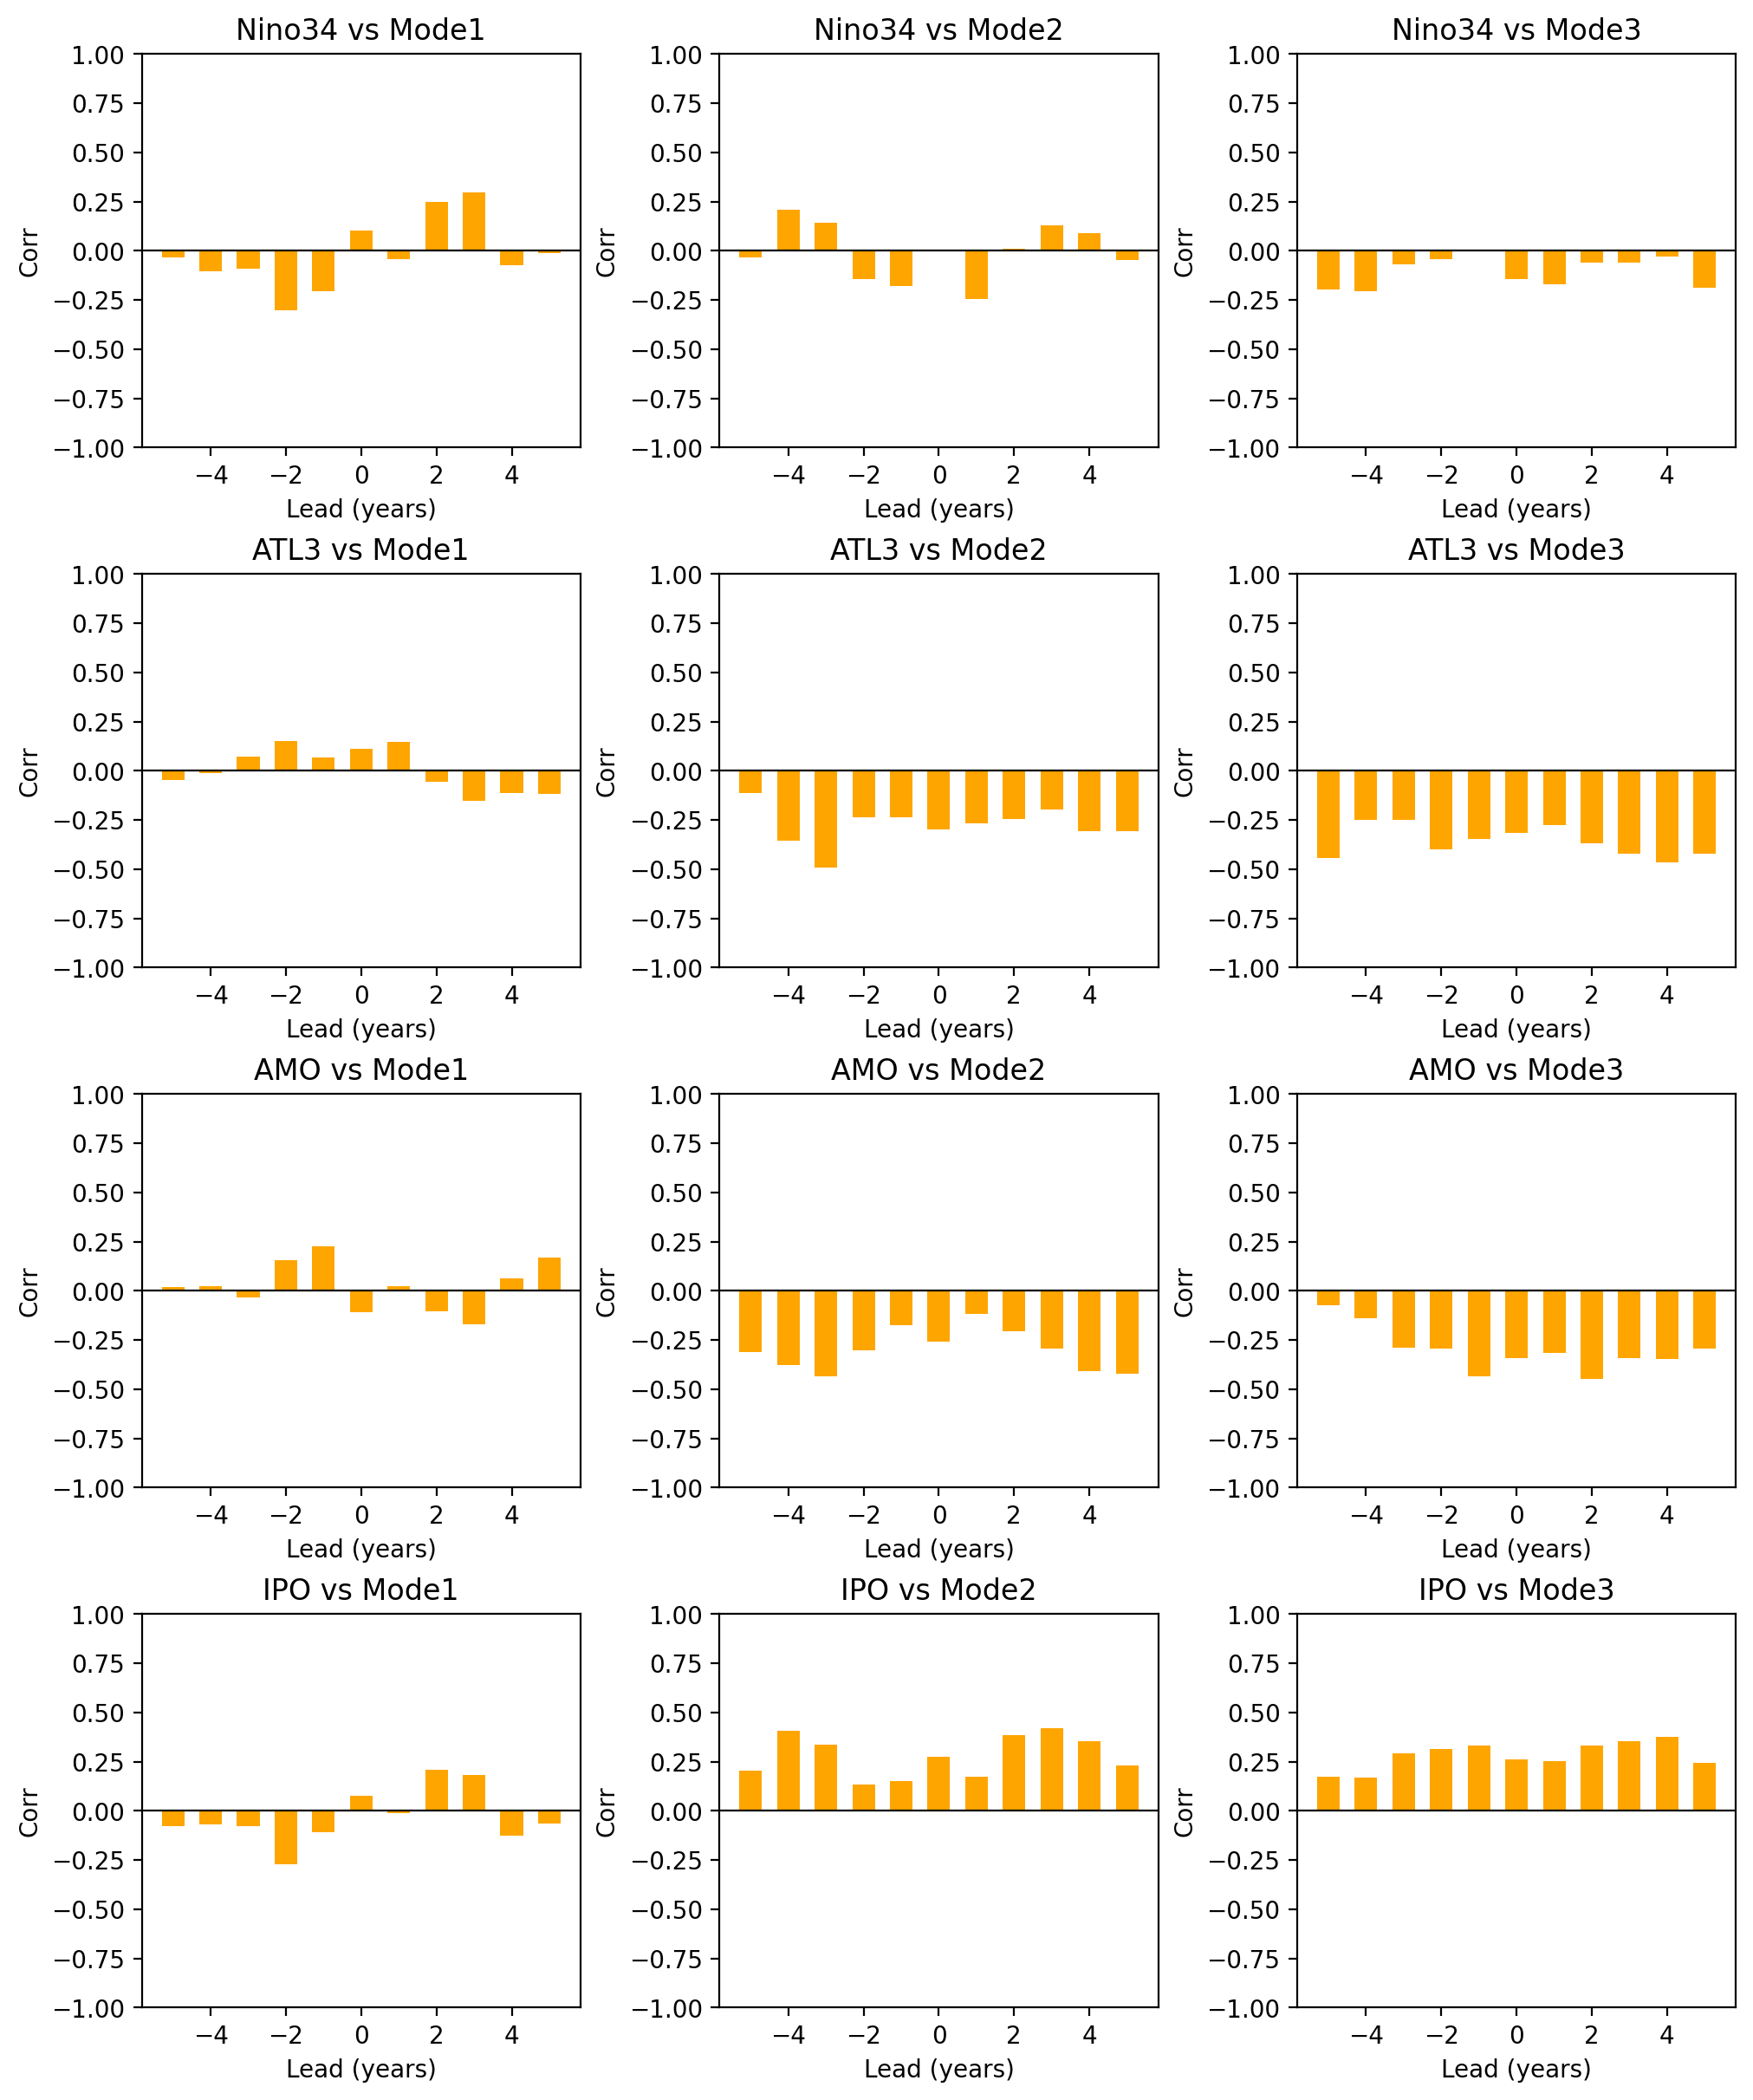

In [165]:
# AMOC lead-lag-corrs

# 1) Define your index DataArrays, each a function of 'year'
#    E.g., xarray objects: ADA_nino34_yearly['SST'].sel(ens_ADA=0)
#          ADA_atl3_yearly['SST'].sel(ens_ADA=0)
#          ADA_amo_yearly['SST'].sel(ens_ADA=0)
index_names = ["Nino34", "ATL3", "AMO", "IPO"]
index_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0),
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0),
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# 2) Define your EOF mode DataArrays, also a function of 'year'
#    E.g. eof_pct.sel(mode=1), sel(mode=2), sel(mode=3)
mode_names = ["Mode1", "Mode2", "Mode3"]
mode_data = [
    eof_pct.sel(mode=1),
    eof_pct.sel(mode=2),
    eof_pct.sel(mode=3),
]

# 3) We will compute lead-lag correlations over leads=-5..5
leads = range(-5, 6)

def compute_lead_lag_corr(x, y, leads):
    """
    x, y: 1D xarray DataArray with dim='year'
    returns: DataArray of shape (n_leads,) for correlation
    """
    corr_list = []
    for lead in leads:
        if lead > 0:
            x_shifted = x.shift(year=lead)  # x leads y
            c = xr.corr(x_shifted, y, dim='year')
        elif lead < 0:
            y_shifted = y.shift(year=-lead) # y leads x
            c = xr.corr(x, y_shifted, dim='year')
        else:
            c = xr.corr(x, y, dim='year')
        corr_list.append(c)
    corr_da = xr.concat(corr_list, dim='lead')
    corr_da['lead'] = list(leads)
    return corr_da

# 4) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 5) Loop over indices (rows) and modes (columns)
for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        
        # x: the selected index data
        x = index_data[i]
        # y: the selected mode data
        y = mode_data[j]
        
        # Compute lead-lag correlation
        corr_da = compute_lead_lag_corr(x, y, leads)
        
        # Bar plot
        ax.bar(corr_da['lead'].values, corr_da.values, color='orange', width=0.6)
        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_xlabel("Lead (years)")
        ax.set_ylabel("Corr")
        
        # Title: e.g. "Nino34 vs Mode1" etc
        ax.set_title(f"{index_names[i]} vs {mode_names[j]}")
        ax.set_ylim(-1, 1)
plt.show()


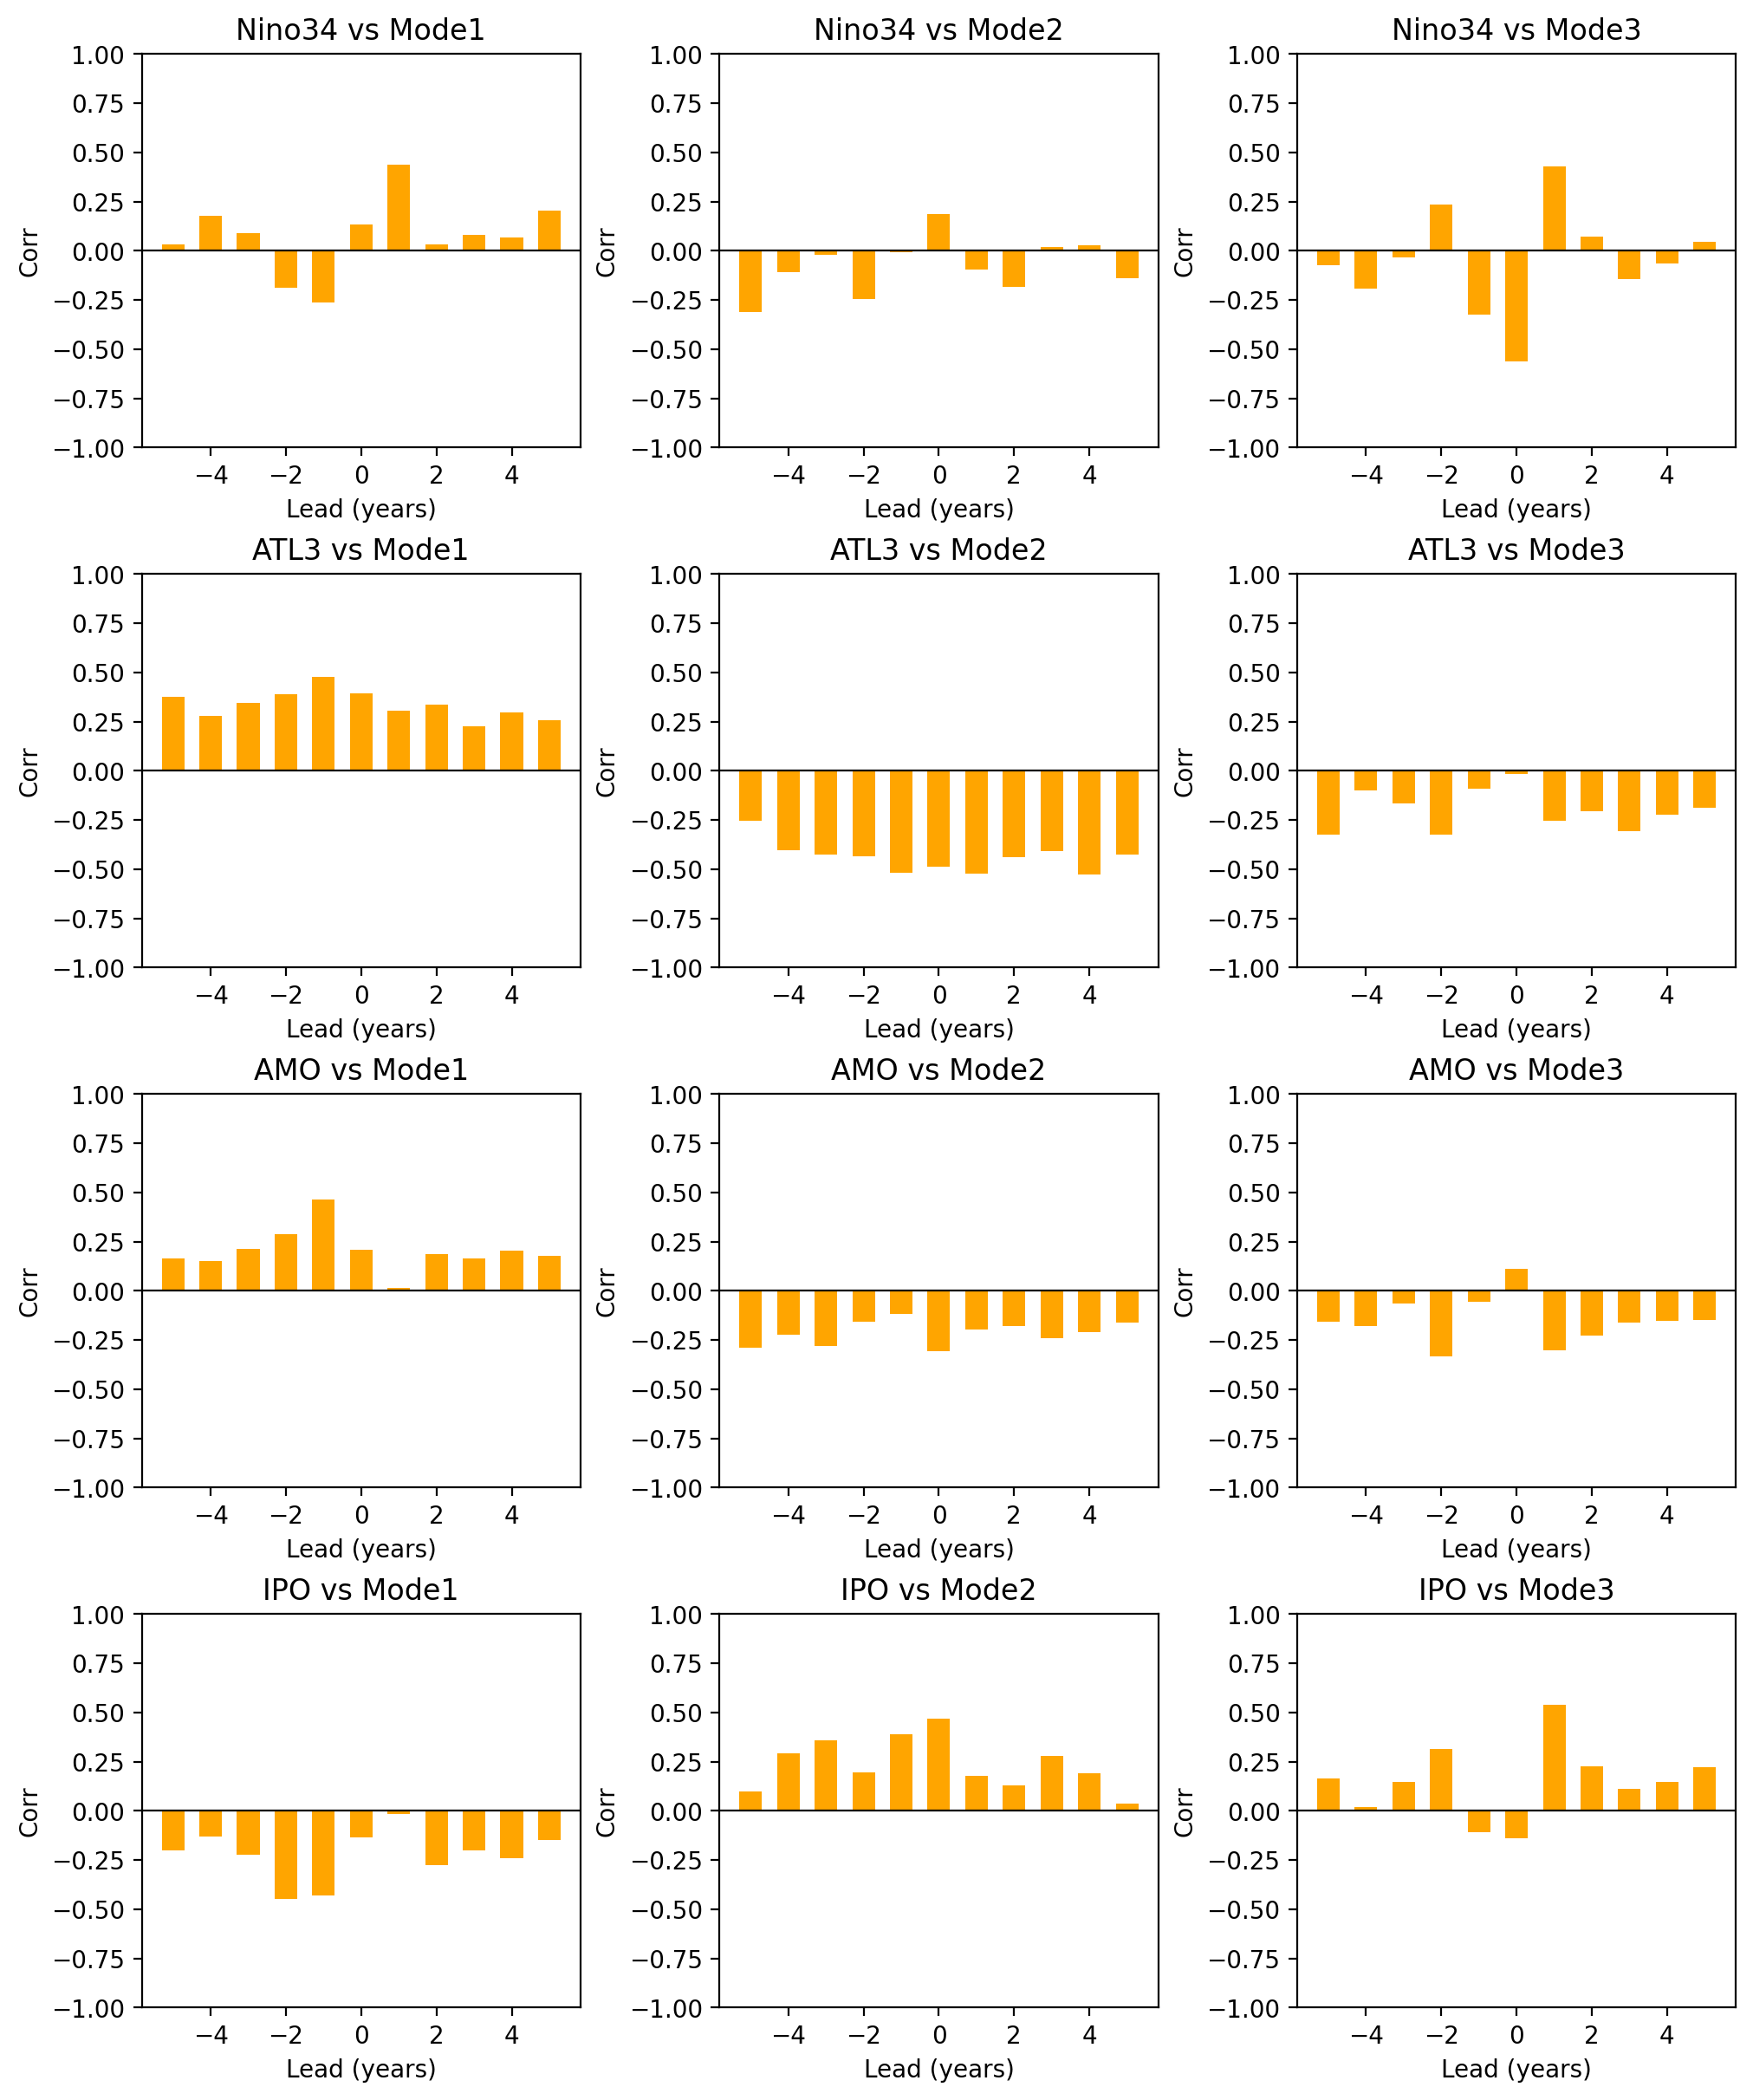

In [166]:
# GLO MOC lead-lag-corrs

# 1) Define your index DataArrays, each a function of 'year'
#    E.g., xarray objects: ADA_nino34_yearly['SST'].sel(ens_ADA=0)
#          ADA_atl3_yearly['SST'].sel(ens_ADA=0)
#          ADA_amo_yearly['SST'].sel(ens_ADA=0)
index_names = ["Nino34", "ATL3", "AMO", "IPO"]
index_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0),
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0),
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# 2) Define your EOF mode DataArrays, also a function of 'year'
#    E.g. eof_pct.sel(mode=1), sel(mode=2), sel(mode=3)
mode_names = ["Mode1", "Mode2", "Mode3"]
mode_data = [
    glo_eof_pct.sel(mode=1),
    glo_eof_pct.sel(mode=2),
    glo_eof_pct.sel(mode=3),
]

# 3) We will compute lead-lag correlations over leads=-5..5
leads = range(-5, 6)

def compute_lead_lag_corr(x, y, leads):
    """
    x, y: 1D xarray DataArray with dim='year'
    returns: DataArray of shape (n_leads,) for correlation
    """
    corr_list = []
    for lead in leads:
        if lead > 0:
            x_shifted = x.shift(year=lead)  # x leads y
            c = xr.corr(x_shifted, y, dim='year')
        elif lead < 0:
            y_shifted = y.shift(year=-lead) # y leads x
            c = xr.corr(x, y_shifted, dim='year')
        else:
            c = xr.corr(x, y, dim='year')
        corr_list.append(c)
    corr_da = xr.concat(corr_list, dim='lead')
    corr_da['lead'] = list(leads)
    return corr_da

# 4) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 5) Loop over indices (rows) and modes (columns)
for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        
        # x: the selected index data
        x = index_data[i]
        # y: the selected mode data
        y = mode_data[j]
        
        # Compute lead-lag correlation
        corr_da = compute_lead_lag_corr(x, y, leads)
        
        # Bar plot
        ax.bar(corr_da['lead'].values, corr_da.values, color='orange', width=0.6)
        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_xlabel("Lead (years)")
        ax.set_ylabel("Corr")
        
        # Title: e.g. "Nino34 vs Mode1" etc
        ax.set_title(f"{index_names[i]} vs {mode_names[j]}")
        ax.set_ylim(-1, 1)
plt.show()


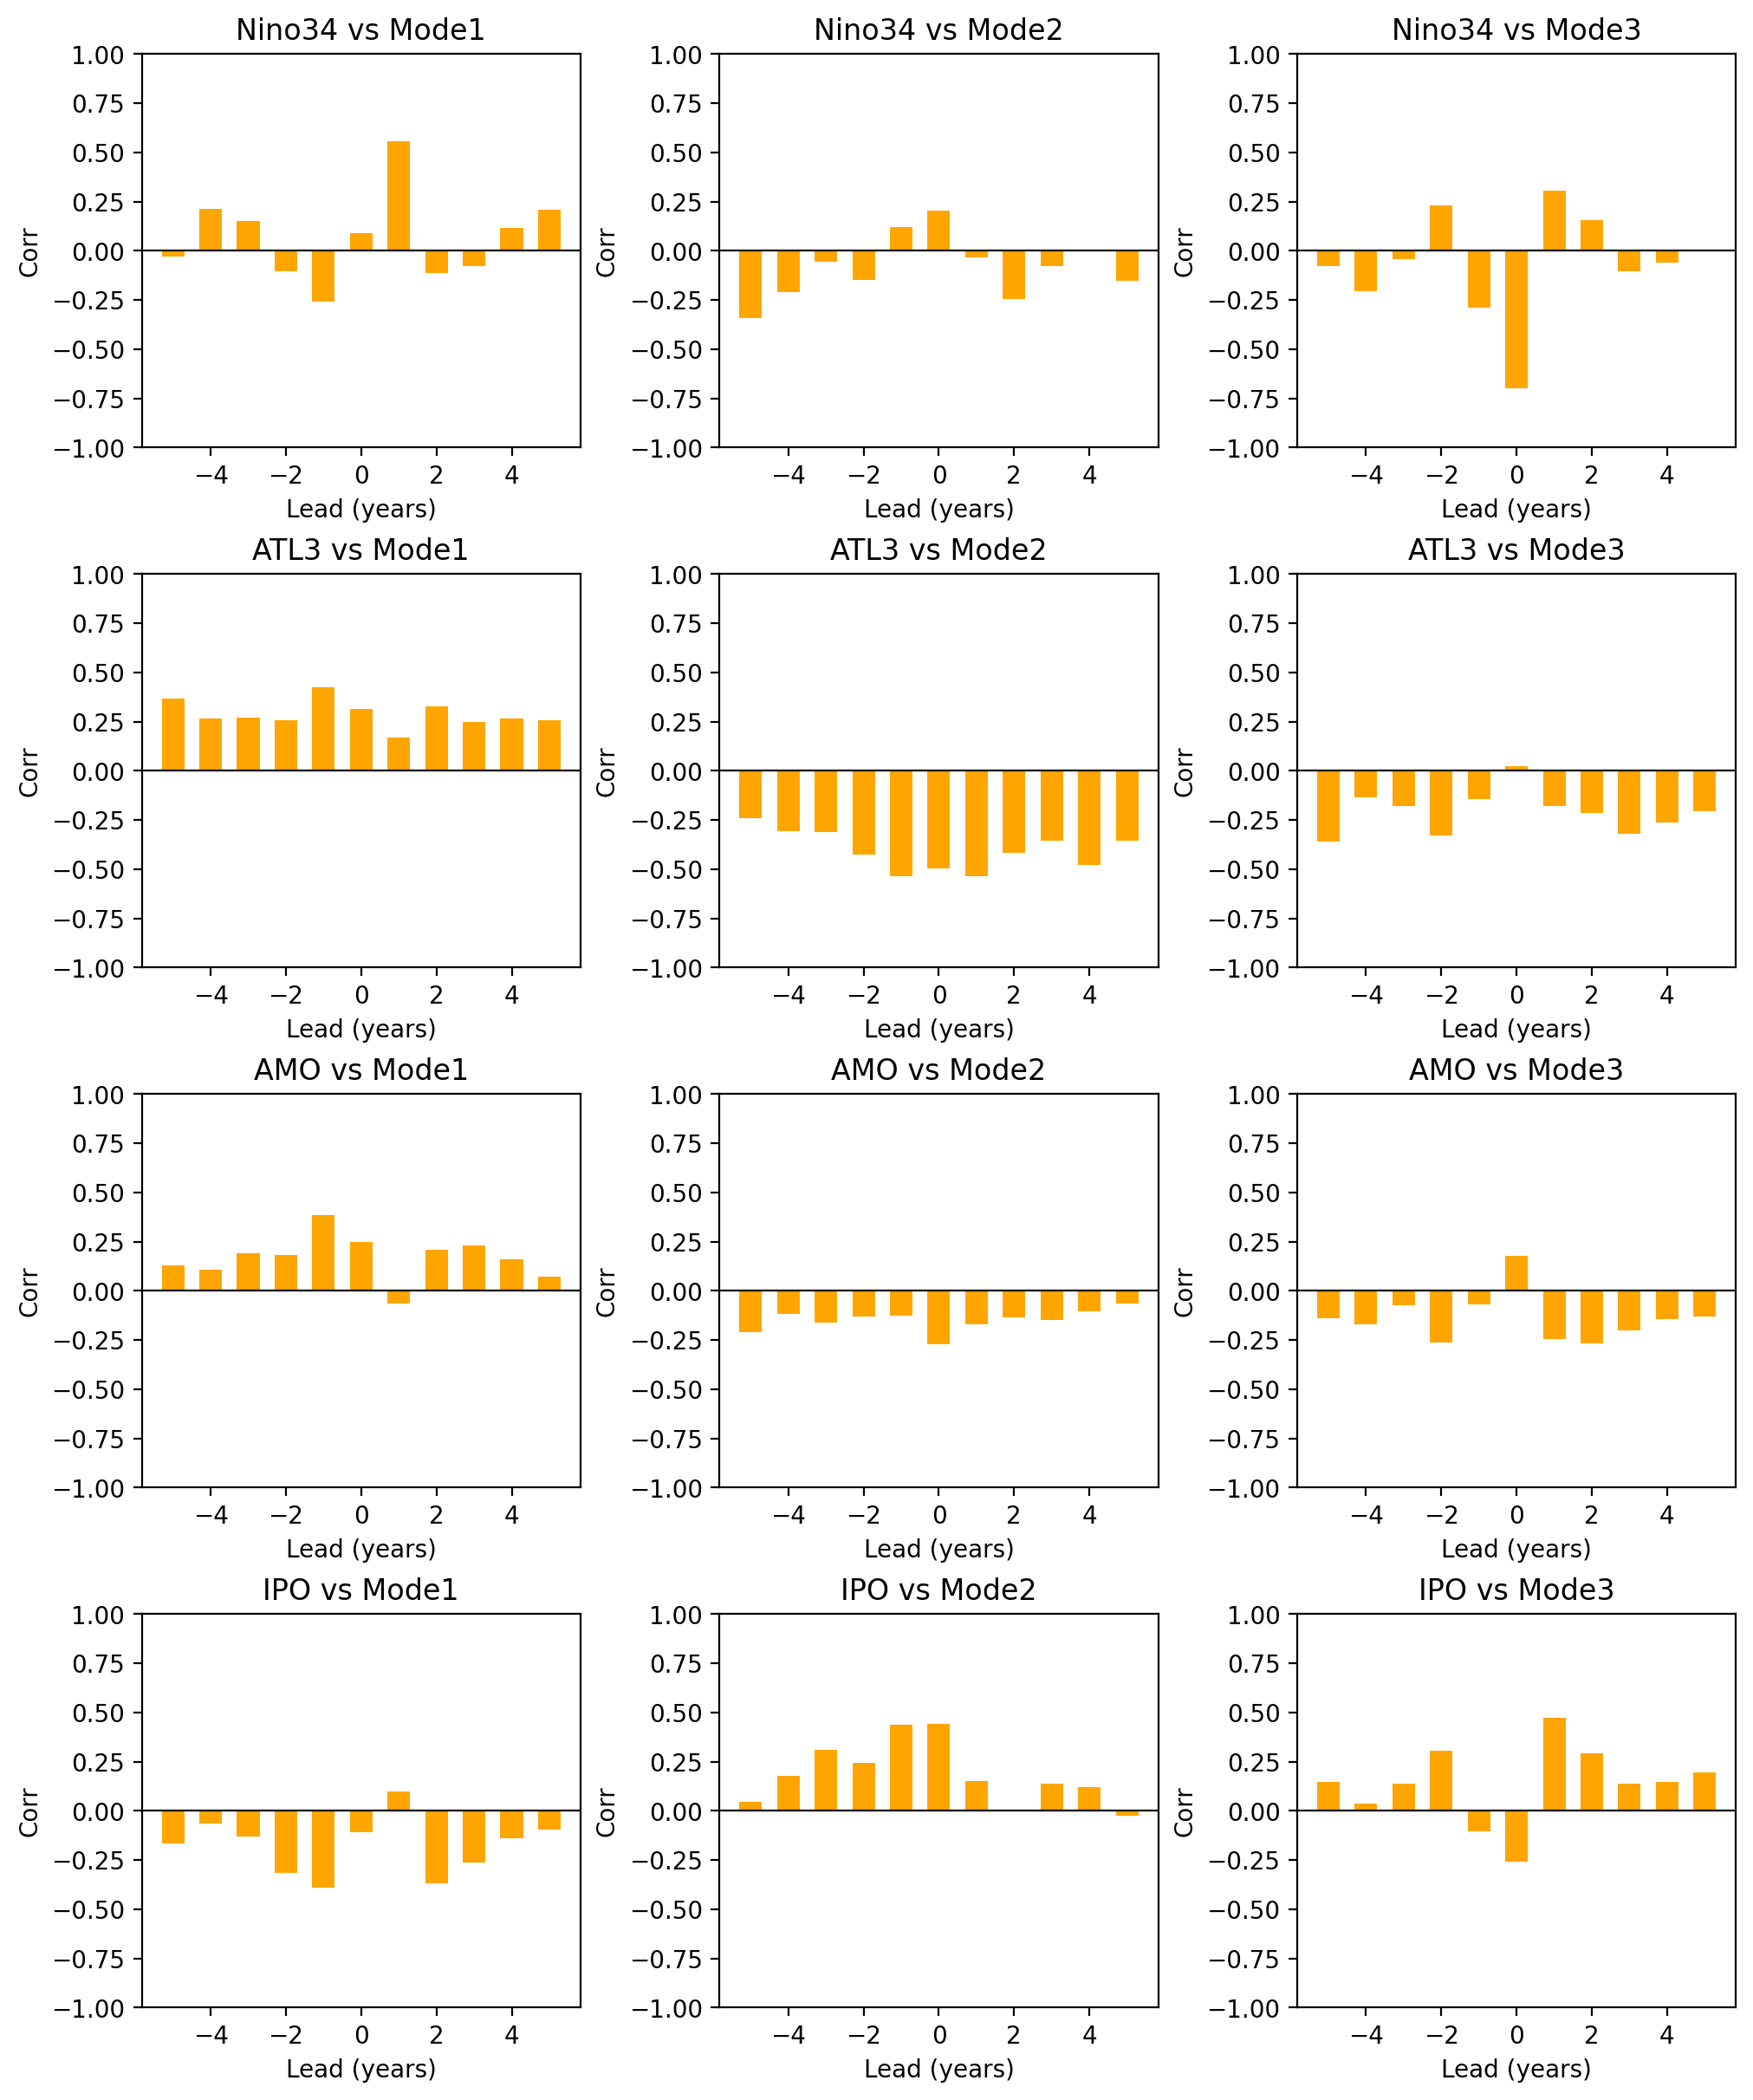

In [167]:
# AP MOC lead-lag-corrs

# 1) Define your index DataArrays, each a function of 'year'
#    E.g., xarray objects: ADA_nino34_yearly['SST'].sel(ens_ADA=0)
#          ADA_atl3_yearly['SST'].sel(ens_ADA=0)
#          ADA_amo_yearly['SST'].sel(ens_ADA=0)
index_names = ["Nino34", "ATL3", "AMO", "IPO"]
index_data = [
    ADA_nino34_yearly['SST'].sel(ens_ADA=0),
    ADA_ATL3_yearly['SST'].sel(ens_ADA=0),
    ADA_AMO_yearly['SST'].sel(ens_ADA=0),
    ADA_IPO_yearly['SST'].sel(ens_ADA=0)
]

# 2) Define your EOF mode DataArrays, also a function of 'year'
#    E.g. eof_pct.sel(mode=1), sel(mode=2), sel(mode=3)
mode_names = ["Mode1", "Mode2", "Mode3"]
mode_data = [
    ap_eof_pct.sel(mode=1),
    ap_eof_pct.sel(mode=2),
    ap_eof_pct.sel(mode=3),
]

# 3) We will compute lead-lag correlations over leads=-5..5
leads = range(-5, 6)

def compute_lead_lag_corr(x, y, leads):
    """
    x, y: 1D xarray DataArray with dim='year'
    returns: DataArray of shape (n_leads,) for correlation
    """
    corr_list = []
    for lead in leads:
        if lead > 0:
            x_shifted = x.shift(year=lead)  # x leads y
            c = xr.corr(x_shifted, y, dim='year')
        elif lead < 0:
            y_shifted = y.shift(year=-lead) # y leads x
            c = xr.corr(x, y_shifted, dim='year')
        else:
            c = xr.corr(x, y, dim='year')
        corr_list.append(c)
    corr_da = xr.concat(corr_list, dim='lead')
    corr_da['lead'] = list(leads)
    return corr_da

# 4) Create a 3×3 figure
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), dpi=200, 
                        facecolor='w', edgecolor='k', constrained_layout=True)

# 5) Loop over indices (rows) and modes (columns)
for i in range(4):
    for j in range(3):
        ax = axs[i, j]
        
        # x: the selected index data
        x = index_data[i]
        # y: the selected mode data
        y = mode_data[j]
        
        # Compute lead-lag correlation
        corr_da = compute_lead_lag_corr(x, y, leads)
        
        # Bar plot
        ax.bar(corr_da['lead'].values, corr_da.values, color='orange', width=0.6)
        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_xlabel("Lead (years)")
        ax.set_ylabel("Corr")
        
        # Title: e.g. "Nino34 vs Mode1" etc
        ax.set_title(f"{index_names[i]} vs {mode_names[j]}")
        ax.set_ylim(-1, 1)
plt.show()
